In [3]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import copy

ITD Round 00: Global Acc = 0.4180, Std(Client Acc) = 0.1613, Total Comm Steps = 15
ITD Round 01: Global Acc = 0.3451, Std(Client Acc) = 0.2044, Total Comm Steps = 13
ITD Round 02: Global Acc = 0.3245, Std(Client Acc) = 0.3009, Total Comm Steps = 12
ITD Round 03: Global Acc = 0.3721, Std(Client Acc) = 0.2935, Total Comm Steps = 13
ITD Round 04: Global Acc = 0.6708, Std(Client Acc) = 0.3203, Total Comm Steps = 12
ITD Round 05: Global Acc = 0.6489, Std(Client Acc) = 0.1591, Total Comm Steps = 15
ITD Round 06: Global Acc = 0.6553, Std(Client Acc) = 0.1236, Total Comm Steps = 12
ITD Round 07: Global Acc = 0.6779, Std(Client Acc) = 0.0654, Total Comm Steps = 10
ITD Round 08: Global Acc = 0.6257, Std(Client Acc) = 0.2782, Total Comm Steps = 12
ITD Round 09: Global Acc = 0.7233, Std(Client Acc) = 0.1987, Total Comm Steps = 10
ITD Round 10: Global Acc = 0.7584, Std(Client Acc) = 0.0841, Total Comm Steps = 8
ITD Round 11: Global Acc = 0.7475, Std(Client Acc) = 0.2435, Total Comm Steps = 12
ITD R

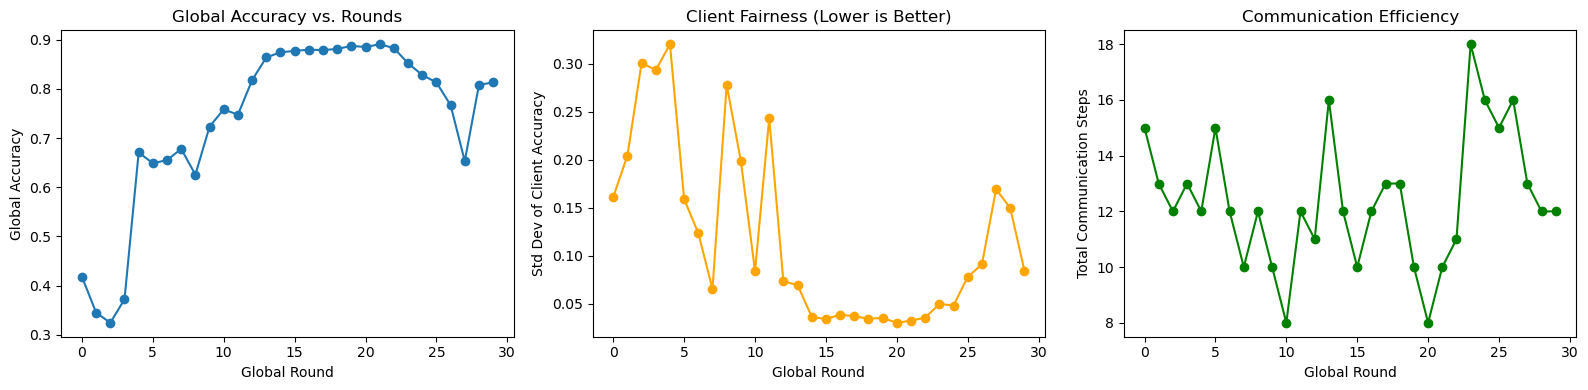


Final Client Accuracies:
Client 0: 0.9585
Client 1: 0.8875
Client 2: 0.8934
Client 3: 0.9104
Client 4: 0.7103


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

# =============================================================================
# User parameters: choose hypergradient method: "averaging" or "ITD"
# =============================================================================
hypergrad_method = "ITD"    # Set to "averaging" for the simple averaging baseline,
                            # or "ITD" for iterative differentiation.
                            
# =============================================================================
# Setup & Data Loading
# =============================================================================
np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# For simplicity, we use the training set for both training and evaluation.

num_clients = 5
indices = np.argsort(np.array(train_dataset.targets))
client_indices = np.array_split(indices, num_clients)
client_loaders = []
batch_size = 64
for idx in client_indices:
    subset = Subset(train_dataset, idx)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    client_loaders.append(loader)

# =============================================================================
# Model Definition and Utility Functions
# =============================================================================
d_in = 28*28
d_out = 10

def vector_to_model(vec):
    # Given a flat vector, returns model as (weight, bias)
    weight = vec[:d_in*d_out].view(d_in, d_out)
    bias = vec[d_in*d_out:].view(d_out)
    return (weight, bias)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    logits = X_flat @ weight + bias
    return logits

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

# For global model we represent it as a flat vector parameter.
def init_global_vector():
    # Use Xavier initialization for weights and zeros for bias.
    weight = torch.empty(d_in, d_out)
    nn.init.xavier_uniform_(weight)
    bias = torch.zeros(d_out)
    vec = torch.cat([weight.view(-1), bias.view(-1)])
    return vec.detach().clone().requires_grad_(True)

# =============================================================================
# Hyperparameters
# =============================================================================
num_outer = 30        # global rounds
max_inner = 5         # maximum local iterations per client
inner_lr = 0.01       # local learning rate
global_lr = 0.5       # global update (smoothing) rate for averaging method
rho = 0.1             # consensus regularization weight in inner objective
eta = 0.1             # fairness penalty weight (can be set to zero if desired)
rel_tol = 0.005       # stopping tolerance for local inner loop
p_comm_init = 0.5     # initial communication probability (for both methods)
alpha_p = 0.01        # adaptation rate for communication probability

# For ITD, we will update global vector via explicit gradient descent.
global_vec = init_global_vector()

# =============================================================================
# Training: Two branches for hypergradient computation
# =============================================================================
global_acc_history = []
client_acc_history = []
communication_history = []
fairness_history = []

# Loop over global rounds
for outer in range(num_outer):
    if hypergrad_method == "averaging":
        # ----- Averaging method: compute local models with detached updates
        client_models = []
        comm_counts = []  # record communications per client
        client_accs = []
        for loader in client_loaders:
            # Initialize local model as a detached copy of the global model.
            local_vec = global_vec.detach().clone()  # note: no grad tracking
            comm_count = 0
            # Perform a fixed number of inner iterations.
            loader_iter = iter(loader)
            for inner in range(max_inner):
                try:
                    X_batch, y_batch = next(loader_iter)
                except StopIteration:
                    loader_iter = iter(loader)
                    X_batch, y_batch = next(loader_iter)
                # Convert local_vec to model.
                local_model = vector_to_model(local_vec)
                loss_val = ce_loss(local_model, X_batch, y_batch)
                # Composite objective: classification loss + consensus term + fairness penalty.
                consensus = (rho/2) * torch.norm(local_vec - global_vec.detach())**2
                # For simplicity, use fairness penalty = eta * max(0, loss - loss_target)^2.
                loss_target = 0.5  # a fixed target (could be computed per round)
                fairness_penalty = eta * (F.relu(loss_val - loss_target))**2
                obj = loss_val + consensus + fairness_penalty
                # Compute gradient by hand (detaching so that the update graph is not preserved).
                grad = torch.autograd.grad(obj, local_vec)[0]
                local_vec = local_vec - inner_lr * grad
                # Communication step: with probability p_comm, average with global model.
                if np.random.rand() < p_comm_init:
                    local_vec = 0.5 * (local_vec + global_vec.detach())
                    comm_count += 1
            comm_counts.append(comm_count)
            # Final local model.
            final_local_model = vector_to_model(local_vec)
            client_models.append(final_local_model)
            # Evaluate on client data.
            correct, tot = 0, 0
            for X_batch, y_batch in loader:
                preds = predict(final_local_model, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            client_acc = correct / tot
            client_accs.append(client_acc)
        # Global update: simple aggregation via averaging of local models.
        # Here, we average the parameter vectors.
        local_vecs = [model_to_vector(m) for m in client_models]
        aggregated_vec = sum(local_vecs) / len(local_vecs)
        # Smoothing update:
        global_vec = (1 - global_lr) * global_vec.detach() + global_lr * aggregated_vec
        global_vec = global_vec.detach().clone().requires_grad_(True)
        comm_total = sum(comm_counts)
        # For evaluation: compute accuracy on each client using updated global model.
        global_model = vector_to_model(global_vec)
        global_accs = []
        for loader in client_loaders:
            correct, tot = 0, 0
            for X_batch, y_batch in loader:
                preds = predict(global_model, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            global_accs.append(correct / tot)
        global_acc = np.mean(global_accs)
        fairness = np.std(client_accs)
        global_acc_history.append(global_acc)
        client_acc_history.append(client_accs)
        communication_history.append(comm_total)
        fairness_history.append(fairness)
        print(f"Averaging Round {outer:02d}: Global Acc = {global_acc:.4f}, Std(Client Acc) = {fairness:.4f}, Total Comm Steps = {comm_total}")
    
    elif hypergrad_method == "ITD":
        # ----- ITD method: differentiate through the inner loop.
        # global_vec is a leaf tensor requiring grad.
        # For each client, we unroll the inner updates without detaching.
        client_outer_losses = []
        comm_counts = []
        client_accs = []
        local_final_vecs = []  # store final local vectors for diagnostic
        for loader in client_loaders:
            local_vec = global_vec.clone()  # start from current global model; keep graph
            comm_count = 0
            loader_iter = iter(loader)
            for inner in range(max_inner):
                try:
                    X_batch, y_batch = next(loader_iter)
                except StopIteration:
                    loader_iter = iter(loader)
                    X_batch, y_batch = next(loader_iter)
                current_model = vector_to_model(local_vec)
                loss_val = ce_loss(current_model, X_batch, y_batch)
                consensus = (rho/2) * torch.norm(local_vec - global_vec)**2
                loss_target = 0.5
                fairness_penalty = eta * (F.relu(loss_val - loss_target))**2
                local_obj = loss_val + consensus + fairness_penalty
                # Do a gradient descent step unrolled (do not detach)
                grad = torch.autograd.grad(local_obj, local_vec, retain_graph=True)[0]
                local_vec = local_vec - inner_lr * grad
                if np.random.rand() < p_comm_init:
                    local_vec = 0.5 * (local_vec + global_vec)  # communication step
                    comm_count += 1
            local_final_vecs.append(local_vec)
            # Compute outer loss on this client on full data (using one pass)
            # We use a simple average of losses.
            client_loss = 0.0
            count_data = 0
            correct, tot = 0, 0
            final_model = vector_to_model(local_vec)
            for X_batch, y_batch in loader:
                l = ce_loss(final_model, X_batch, y_batch)
                client_loss += l * X_batch.shape[0]
                count_data += X_batch.shape[0]
                preds = predict(final_model, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            client_loss = client_loss / count_data
            client_outer_losses.append(client_loss)
            client_acc = correct / tot
            client_accs.append(client_acc)
            comm_counts.append(comm_count)
        # The outer objective is the average of client outer losses.
        outer_obj = sum(client_outer_losses) / len(client_outer_losses)
        # Compute gradient of outer_obj with respect to global_vec.
        hypergrad = torch.autograd.grad(outer_obj, global_vec)[0]
        # Update the global model using a simple gradient descent step on global_vec.
        with torch.no_grad():
            global_vec = global_vec - global_lr * hypergrad
        global_vec = global_vec.detach().clone().requires_grad_(True)
        comm_total = sum(comm_counts)
        # Evaluate updated global model:
        global_model = vector_to_model(global_vec)
        global_accs = []
        for loader in client_loaders:
            correct, tot = 0, 0
            for X_batch, y_batch in loader:
                preds = predict(global_model, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            global_accs.append(correct / tot)
        global_acc = np.mean(global_accs)
        fairness = np.std(client_accs)
        global_acc_history.append(global_acc)
        client_acc_history.append(client_accs)
        communication_history.append(comm_total)
        fairness_history.append(fairness)
        print(f"ITD Round {outer:02d}: Global Acc = {global_acc:.4f}, Std(Client Acc) = {fairness:.4f}, Total Comm Steps = {comm_total}")
    else:
        raise ValueError("Unrecognized hypergradient method. Choose 'averaging' or 'ITD'.")

# =============================================================================
# Visualization
# =============================================================================
rounds = np.arange(num_outer)
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.plot(rounds, global_acc_history, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Global Accuracy")
plt.title("Global Accuracy vs. Rounds")

plt.subplot(1,3,2)
plt.plot(rounds, fairness_history, marker='o', color='orange')
plt.xlabel("Global Round")
plt.ylabel("Std Dev of Client Accuracy")
plt.title("Client Fairness (Lower is Better)")

plt.subplot(1,3,3)
plt.plot(rounds, communication_history, marker='o', color='green')
plt.xlabel("Global Round")
plt.ylabel("Total Communication Steps")
plt.title("Communication Efficiency")

plt.tight_layout()
plt.show()

print("\nFinal Client Accuracies:")
for i, acc in enumerate(client_acc_history[-1]):
    print(f"Client {i}: {acc:.4f}")


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

# =============================================================================
# User parameters: choose hypergradient method:
# Options: "averaging", "ITD", "AID", "FD"
# =============================================================================
hypergrad_method = "ITD"   # Change as desired

# =============================================================================
# Setup & Data Loading
# =============================================================================
np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# For simplicity, we'll use the training set as our data.

num_clients = 5
indices = np.argsort(np.array(train_dataset.targets))
client_indices = np.array_split(indices, num_clients)
client_loaders = []
batch_size = 64
for idx in client_indices:
    subset = Subset(train_dataset, idx)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    client_loaders.append(loader)

# =============================================================================
# Model Definition and Utility Functions
# =============================================================================
d_in = 28*28
d_out = 10

def vector_to_model(vec):
    weight = vec[:d_in*d_out].view(d_in, d_out)
    bias   = vec[d_in*d_out:].view(d_out)
    return (weight, bias)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    logits = X_flat @ weight + bias
    return logits

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

# Initialize global model as a flat vector using Xavier initialization.
def init_global_vector():
    weight = torch.empty(d_in, d_out)
    nn.init.xavier_uniform_(weight)
    bias = torch.zeros(d_out)
    vec = torch.cat([weight.view(-1), bias.view(-1)])
    return vec.detach().clone().requires_grad_(True)

# =============================================================================
# Conjugate Gradient Solver for AID
# =============================================================================
def cg_solve(Ax_fn, b, tol=1e-5, max_iter=50):
    # Solve A v = b using conjugate gradient
    v = torch.zeros_like(b)
    r = b.clone()
    d = r.clone()
    delta_new = torch.dot(r, r)
    delta_0 = delta_new.clone()
    for i in range(max_iter):
        q = Ax_fn(d)
        alpha = delta_new / (torch.dot(d, q) + 1e-8)
        v = v + alpha * d
        r = r - alpha * q
        delta_old = delta_new
        delta_new = torch.dot(r, r)
        if delta_new < tol * delta_0:
            break
        beta = delta_new / (delta_old + 1e-8)
        d = r + beta * d
    return v

# =============================================================================
# Hyperparameters
# =============================================================================
num_outer = 500         # Number of global rounds
max_inner = 5          # Maximum local (inner) iterations per client
inner_lr = 0.01        # Local learning rate
global_lr = 0.5        # Global update (for averaging/FD) or step size for hypergradient (ITD/AID/FD)
rho   = 0.1            # Consensus weight (keeps local model near global model)
eta   = 0.1            # Fairness penalty weight
rel_tol = 0.005        # Tolerance to stop inner loop
p_comm = 0.5           # Communication probability (ProxSkip)
alpha_p = 0.01         # Adaptation rate for p_comm

# For FD method: finite difference epsilon
fd_eps = 1e-3

# =============================================================================
# Initialize global model as a flat vector
# =============================================================================
global_vec = init_global_vector()

# =============================================================================
# Training Loop: Switch on hypergradient method
# =============================================================================
global_acc_history = []
client_acc_history = []      # list (per round) of client accuracies
communication_history = []   # total communication steps per round
fairness_history = []        # std dev of client accuracies

for outer in range(num_outer):
    # For each client we will compute a local solution y_i*(global_vec)
    # We'll use a mini-batch from each client for computing gradients.
    client_local_vecs = []    # store final local vectors (could be detached or not depending on method)
    comm_counts = []          # record number of communication steps (simulated)
    client_accs = []          # store accuracy per client

    # For methods that require differentiability (ITD, AID, FD), do not detach inner loop.
    # unroll = hypergrad_method in ["ITD", "AID", "FD"]
    unroll = hypergrad_method in ["ITD"]
    
    for loader in client_loaders:
        # For each client, initialize local vector from global_vec.
        if unroll:
            local_vec = global_vec.clone()  # keep graph
        else:
            local_vec = global_vec.detach().clone()  # no graph
        local_vec.requires_grad_(True)
        
        comm_count = 0
        loader_iter = iter(loader)
        # Run local (inner) iterations
        for inner in range(max_inner):
            try:
                X_batch, y_batch = next(loader_iter)
            except StopIteration:
                loader_iter = iter(loader)
                X_batch, y_batch = next(loader_iter)
            
            # For each client, define its inner objective.
            # Here, we use:
            #   f(y) = ce_loss(model_from(local_vec), X_batch, y_batch)
            #   plus consensus term: (rho/2)*||local_vec - global_vec||^2
            #   plus fairness penalty: eta * (F.relu(f(y) - loss_target))^2
            loss_val = ce_loss(vector_to_model(local_vec), X_batch, y_batch)
            loss_target = 0.5  # a fixed target (for illustration)
            fairness_penalty = eta * (F.relu(loss_val - loss_target))**2
            if unroll:
                # In ITD/AID/FD, global_vec is used in the consensus term in a differentiable way.
                consensus = (rho/2) * torch.norm(local_vec - global_vec)**2
            else:
                consensus = (rho/2) * torch.norm(local_vec - global_vec.detach())**2
            inner_obj = loss_val + consensus + fairness_penalty
            
            # For ITD and FD/AID unrolling, do differentiable update.
            grads = torch.autograd.grad(inner_obj, local_vec, retain_graph=unroll)[0]
            local_vec = local_vec - inner_lr * grads
            
            # Communication (ProxSkip-inspired): with probability p_comm, average with global_vec.
            if np.random.rand() < p_comm:
                if unroll:
                    local_vec = 0.5 * (local_vec + global_vec)
                else:
                    local_vec = 0.5 * (local_vec + global_vec.detach())
                comm_count += 1
        
        client_local_vecs.append(local_vec)  # keep local_vec (for ITD/AID, graph preserved)
        comm_counts.append(comm_count)
        
        # Evaluate the final local model on the client's data (detached evaluation).
        final_model = vector_to_model(local_vec.detach())
        correct, tot = 0, 0
        for X_batch, y_batch in loader:
            preds = predict(final_model, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        client_accs.append(correct/tot)
    
    # Global update: now choose how to compute the hypergradient with respect to global_vec.
    if hypergrad_method == "averaging":
        # Simple averaging of local final vectors (detached) and then update global_vec as convex combination.
        local_vecs_detached = [v.detach() for v in client_local_vecs]
        aggregated_vec = sum(local_vecs_detached) / len(local_vecs_detached)
        # Smoothing update:
        global_vec = (1 - global_lr) * global_vec.detach() + global_lr * aggregated_vec
        global_vec = global_vec.detach().clone().requires_grad_(True)
        hypergrad_norm = None  # not computed explicitly
      
    elif hypergrad_method == "ITD":
        # In ITD, the outer objective is computed by averaging the local (unrolled) objectives.
        # We use a single mini-batch evaluation per client (could extend to full data).
        outer_loss = 0.0
        for i, loader in enumerate(client_loaders):
            # Use one mini-batch from each client for the outer evaluation.
            try:
                X_batch, y_batch = next(iter(loader))
            except StopIteration:
                continue
            model_i = vector_to_model(client_local_vecs[i])
            outer_loss = outer_loss + ce_loss(model_i, X_batch, y_batch)
        outer_loss = outer_loss / num_clients
        hypergrad = torch.autograd.grad(outer_loss, global_vec)[0]
        with torch.no_grad():
            global_vec = global_vec - global_lr * hypergrad
        global_vec = global_vec.detach().clone().requires_grad_(True)
        hypergrad_norm = hypergrad.norm().item()
        
    elif hypergrad_method == "AID":
        # For AID, we compute for each client:
        #   b = grad_y ce_loss(model, X_batch, y_batch) computed at the final local vector (using one mini-batch)
        #   Solve: H v = b, where H = Hessian_y^2 (f + (rho/2)||y - global_vec||^2)
        #   Then, hypergrad_i = rho * v. Global hypergradient is average over clients.
        hypergrad_clients = []
        for i, loader in enumerate(client_loaders):
            try:
                X_batch, y_batch = next(iter(loader))
            except StopIteration:
                continue
            # f_i(y) = ce_loss of client i.
            model_i = vector_to_model(client_local_vecs[i])
            f_val = ce_loss(model_i, X_batch, y_batch)
            # Compute b = grad_y f_val with respect to local vector.
            b = torch.autograd.grad(f_val, client_local_vecs[i], retain_graph=True)[0]
            # Define Hessian-vector product function for H = ∇²_y [ f_val + (rho/2)||y - global_vec||^2 ]
            def hvp(d):
                # Compute gradient of f_val + consensus term
                cons = (rho/2) * torch.norm(client_local_vecs[i] - global_vec)**2
                g_val = f_val + cons
                grad_y = torch.autograd.grad(g_val, client_local_vecs[i], create_graph=True)[0]
                Hd = torch.autograd.grad(grad_y, client_local_vecs[i], grad_outputs=d, retain_graph=True)[0]
                return Hd
            v_i = cg_solve(hvp, b, tol=1e-5, max_iter=50)
            hypergrad_clients.append(rho * v_i)
        hypergrad = sum(hypergrad_clients) / len(hypergrad_clients)
        with torch.no_grad():
            global_vec = global_vec - global_lr * hypergrad
        global_vec = global_vec.detach().clone().requires_grad_(True)
        hypergrad_norm = hypergrad.norm().item()
        
    elif hypergrad_method == "FD":
        # Finite difference: approximate global objective L(x) = average_{clients} ce_loss(model(x), batch)
        # Then hypergrad ≈ (L(x+eps) - L(x-eps))/(2*eps)
        eps = fd_eps
        global_vec_plus = global_vec + eps
        global_vec_minus = global_vec - eps
        loss_plus = 0.0
        loss_minus = 0.0
        for i, loader in enumerate(client_loaders):
            try:
                X_batch, y_batch = next(iter(loader))
            except StopIteration:
                continue
            model_plus = vector_to_model(global_vec_plus)
            model_minus = vector_to_model(global_vec_minus)
            loss_plus += ce_loss(model_plus, X_batch, y_batch)
            loss_minus += ce_loss(model_minus, X_batch, y_batch)
        loss_plus = loss_plus / num_clients
        loss_minus = loss_minus / num_clients
        hypergrad = (loss_plus - loss_minus) / (2 * eps)
        # Note: hypergrad here is a scalar; we then form a vector by multiplying by ones.
        hypergrad = hypergrad * torch.ones_like(global_vec)
        with torch.no_grad():
            global_vec = global_vec - global_lr * hypergrad
        global_vec = global_vec.detach().clone().requires_grad_(True)
        hypergrad_norm = hypergrad.norm().item()
    else:
        raise ValueError("Unsupported hypergradient method")
    
    # Evaluate global model (convert global_vec to model) on each client.
    global_model = vector_to_model(global_vec)
    global_accs = []
    for loader in client_loaders:
        correct, tot = 0, 0
        for X_batch, y_batch in loader:
            preds = predict(global_model, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        global_accs.append(correct / tot)
    global_acc = np.mean(global_accs)
    
    # Record metrics.
    global_acc_history.append(global_acc)
    client_acc_history.append(client_accs)
    communication_history.append(sum(comm_counts))
    fairness_history.append(np.std(client_accs))
    
    print(f"Round {outer:02d} [{hypergrad_method}]: Global Acc = {global_acc:.4f}, "
          f"Std(Client Acc) = {np.std(client_accs):.4f}, Total Comm Steps = {sum(comm_counts)}, "
          f"Hypergrad Norm = {hypergrad_norm if hypergrad_norm is not None else 'N/A'}")

# =============================================================================
# Visualization
# =============================================================================
rounds = np.arange(num_outer)
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.plot(rounds, global_acc_history, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Global Accuracy")
plt.title("Global Accuracy vs. Rounds")

plt.subplot(1,3,2)
plt.plot(rounds, fairness_history, marker='o', color='orange')
plt.xlabel("Global Round")
plt.ylabel("Std Dev of Client Accuracies")
plt.title("Client Fairness (Lower is Better)")

plt.subplot(1,3,3)
plt.plot(rounds, communication_history, marker='o', color='green')
plt.xlabel("Global Round")
plt.ylabel("Total Communication Steps")
plt.title("Communication Efficiency")

plt.tight_layout()
plt.show()

print("\nFinal Client Accuracies:")
for i, acc in enumerate(client_acc_history[-1]):
    print(f"Client {i}: {acc:.4f}")


Round 00 [ITD]: Global Acc = 0.3944, Std(Client Acc) = 0.1613, Total Comm Steps = 15, Hypergrad Norm = 3.0214946269989014
Round 01 [ITD]: Global Acc = 0.3012, Std(Client Acc) = 0.1852, Total Comm Steps = 13, Hypergrad Norm = 3.4466114044189453
Round 02 [ITD]: Global Acc = 0.3513, Std(Client Acc) = 0.2802, Total Comm Steps = 12, Hypergrad Norm = 4.957587242126465
Round 03 [ITD]: Global Acc = 0.3615, Std(Client Acc) = 0.2112, Total Comm Steps = 13, Hypergrad Norm = 4.833783149719238


KeyboardInterrupt: 

Round 00 [ITD]: Global Acc = 0.3546, Global Loss = 1.8814, Avg Client Loss = 1.9296, Std(Client Loss) = 0.4792, Std(Client Acc) = 0.1019, Total Comm Steps = 28, Hypergrad Norm = 2.352344036102295
Round 01 [ITD]: Global Acc = 0.3790, Global Loss = 2.1952, Avg Client Loss = 2.1703, Std(Client Loss) = 1.0847, Std(Client Acc) = 0.3020, Total Comm Steps = 25, Hypergrad Norm = 3.1073837280273438
Round 02 [ITD]: Global Acc = 0.6366, Global Loss = 1.0493, Avg Client Loss = 1.0830, Std(Client Loss) = 0.4020, Std(Client Acc) = 0.1836, Total Comm Steps = 27, Hypergrad Norm = 2.1914591789245605
Round 03 [ITD]: Global Acc = 0.6461, Global Loss = 1.0969, Avg Client Loss = 1.1172, Std(Client Loss) = 0.7368, Std(Client Acc) = 0.2542, Total Comm Steps = 22, Hypergrad Norm = 1.5306286811828613
Round 04 [ITD]: Global Acc = 0.6941, Global Loss = 0.9108, Avg Client Loss = 0.9404, Std(Client Loss) = 0.5978, Std(Client Acc) = 0.2375, Total Comm Steps = 22, Hypergrad Norm = 1.1423674821853638
Round 05 [ITD]: 

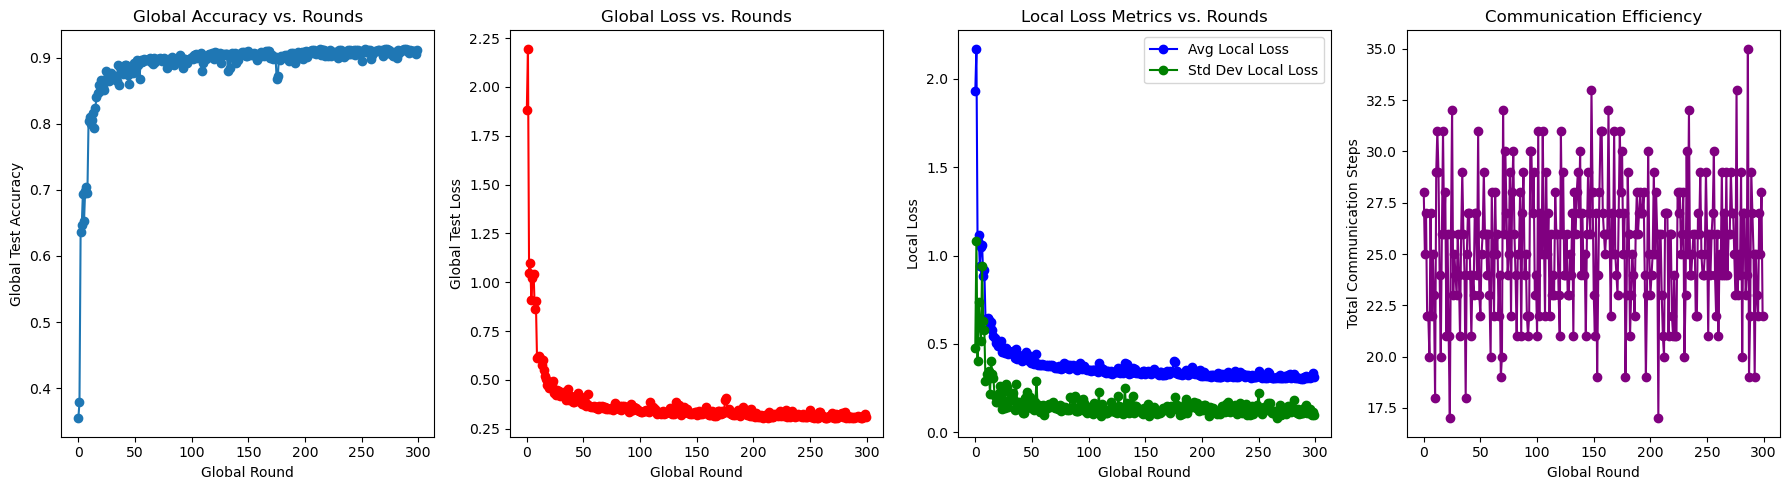


Final Client Accuracies:
Client 0: 0.9684
Client 1: 0.8892
Client 2: 0.8851
Client 3: 0.9153
Client 4: 0.8885


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

# =============================================================================
# User parameters: choose hypergradient method:
# Options: "averaging", "ITD", "AID", "FD"
# =============================================================================
hypergrad_method = "ITD"   # Change as desired

# =============================================================================
# Setup & Data Loading
# =============================================================================
np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# For simplicity, we'll use the training set as our data.

num_clients = 5
indices = np.argsort(np.array(train_dataset.targets))
client_indices = np.array_split(indices, num_clients)
client_loaders = []
batch_size = 64
for idx in client_indices:
    subset = Subset(train_dataset, idx)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    client_loaders.append(loader)

# =============================================================================
# Model Definition and Utility Functions
# =============================================================================
d_in = 28*28
d_out = 10

def vector_to_model(vec):
    weight = vec[:d_in*d_out].view(d_in, d_out)
    bias   = vec[d_in*d_out:].view(d_out)
    return (weight, bias)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    logits = X_flat @ weight + bias
    return logits

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

# Initialize global model as a flat vector using Xavier initialization.
def init_global_vector():
    weight = torch.empty(d_in, d_out)
    nn.init.xavier_uniform_(weight)
    bias = torch.zeros(d_out)
    vec = torch.cat([weight.view(-1), bias.view(-1)])
    return vec.detach().clone().requires_grad_(True)

# Global update: update using hypergradient step.
def update_global_model(global_model, update_vec, lr):
    global_vec = model_to_vector(global_model)
    new_vec = global_vec - lr * update_vec
    return vector_to_model(new_vec)

# =============================================================================
# Conjugate Gradient Solver for AID
# =============================================================================
def cg_solve(Ax_fn, b, tol=1e-5, max_iter=50):
    # Solve A v = b using conjugate gradient
    v = torch.zeros_like(b)
    r = b.clone()
    d = r.clone()
    delta_new = torch.dot(r, r)
    delta_0 = delta_new.clone()
    for i in range(max_iter):
        q = Ax_fn(d)
        alpha = delta_new / (torch.dot(d, q) + 1e-8)
        v = v + alpha * d
        r = r - alpha * q
        delta_old = delta_new
        delta_new = torch.dot(r, r)
        if delta_new < tol * delta_0:
            break
        beta = delta_new / (delta_old + 1e-8)
        d = r + beta * d
    return v

def flatten_grad(grads):
    return torch.cat([g.contiguous().view(-1) for g in grads])

# =============================================================================
# Hyperparameters
# =============================================================================
num_outer = 300         # Number of global rounds
max_inner = 10           # Number of local (inner) iterations per client
inner_lr = 0.01         # Local learning rate
global_lr = 0.2         # Global update step size (applied to hypergradient)
rho   = 0.1             # Consensus weight (keeps local model near global model)
eta   = 0.1             # Fairness penalty weight
rel_tol = 0.005         # Tolerance to stop inner loop (if used)
p_comm = 0.5            # Communication probability (ProxSkip)
alpha_p = 0.01          # Adaptation rate for p_comm

# For FD method: finite difference epsilon
fd_eps = 1e-3

# =============================================================================
# Initialize global model as a flat vector
# =============================================================================
global_vec = init_global_vector()

# =============================================================================
# Training Loop: Hypergradient Methods and Metric Tracking
# =============================================================================

global_acc_history = []
global_loss_history = []       # Global loss evaluated on test set
local_loss_avg_history = []    # Average local loss across clients per round
local_loss_std_history = []    # Standard deviation of local losses
client_acc_history = []        # List (per round) of client accuracies
communication_history = []     # Total communication steps per round
fairness_history = []          # Std deviation of client accuracies

# For evaluation, we create a test loader (using MNIST test set)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

for outer in range(num_outer):
    client_local_vecs = []    # Final local vectors from each client (may retain graph for ITD)
    comm_counts = []          # Communication count per client
    client_accs = []          # Accuracy per client
    client_losses = []        # Average loss per client (on training partition)
    
    # Compute fairness target: evaluate global model on each client's training data.
    eval_losses = []
    for loader in client_loaders:
        loss_sum, count = 0, 0
        for X_batch, y_batch in loader:
            loss = ce_loss(vector_to_model(global_vec), X_batch, y_batch).item()
            loss_sum += loss * X_batch.shape[0]
            count += X_batch.shape[0]
        eval_losses.append(loss_sum / count)
    fairness_target = min(eval_losses)
    
    # For ITD, we want to retain the computation graph, so we "unroll" inner updates.
    # unroll = hypergrad_method in ["ITD", "FD"]  # For FD we unroll as well.
    unroll = hypergrad_method in ["ITD"] 
    
    for loader in client_loaders:
        if unroll:
            local_vec = global_vec.clone()  # graph maintained
        else:
            local_vec = global_vec.detach().clone()
        local_vec.requires_grad_(True)
        comm_count = 0
        loader_iter = iter(loader)
        # Local inner iterations:
        for inner in range(max_inner):
            try:
                X_batch, y_batch = next(loader_iter)
            except StopIteration:
                loader_iter = iter(loader)
                X_batch, y_batch = next(loader_iter)
            
            # Compute inner objective:
            # objective = ce_loss + consensus term + fairness penalty.
            loss_val = ce_loss(vector_to_model(local_vec), X_batch, y_batch)
            loss_target = 0.5  # fixed target for fairness (for illustration)
            fairness_penalty = eta * (F.relu(loss_val - loss_target))**2
            # Consensus term: penalize divergence from global_vec (differentiable update)
            consensus = (rho/2) * torch.norm(local_vec - global_vec)**2
            inner_obj = loss_val + consensus + fairness_penalty
            
            grads = torch.autograd.grad(inner_obj, local_vec, retain_graph=unroll)[0]
            local_vec = local_vec - inner_lr * grads
            
            # Communication step (simulate ProxSkip):
            if np.random.rand() < p_comm:
                if unroll:
                    local_vec = 0.5 * (local_vec + global_vec)
                else:
                    local_vec = 0.5 * (local_vec + global_vec.detach())
                comm_count += 1
        
        client_local_vecs.append(local_vec)
        comm_counts.append(comm_count)
        
        # Evaluate local model on client's training data.
        loss_sum, count = 0, 0
        correct, tot = 0, 0
        for X_batch, y_batch in loader:
            loss = ce_loss(vector_to_model(local_vec.detach()), X_batch, y_batch).item()
            loss_sum += loss * X_batch.shape[0]
            count += X_batch.shape[0]
            preds = predict(vector_to_model(local_vec.detach()), X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        client_losses.append(loss_sum / count)
        client_accs.append(correct / tot)
    
    # Compute hypergradient and update global model based on selected method.
    if hypergrad_method == "averaging":
        # Current approach: average the detached local vectors.
        local_vecs_detached = [v.detach() for v in client_local_vecs]
        aggregated_vec = sum(local_vecs_detached) / len(local_vecs_detached)
        # Surrogate hypergradient: (global_vec - aggregated_vec) / global_lr
        hypergrad = (model_to_vector(vector_to_model(global_vec)) - model_to_vector(vector_to_model(aggregated_vec))) / global_lr
        # Smoothing update:
        global_vec = (1 - global_lr) * global_vec.detach() + global_lr * aggregated_vec
        global_vec = global_vec.detach().clone().requires_grad_(True)
        hypergrad_norm = None
    elif hypergrad_method == "ITD":
        # ITD: define an outer loss that averages one mini-batch evaluation on each client using the unrolled local model.
        outer_loss = 0.0
        for i, loader in enumerate(client_loaders):
            try:
                X_batch, y_batch = next(iter(loader))
            except StopIteration:
                continue
            model_i = vector_to_model(client_local_vecs[i])
            outer_loss = outer_loss + ce_loss(model_i, X_batch, y_batch)
        outer_loss = outer_loss / num_clients
        hypergrad = torch.autograd.grad(outer_loss, global_vec)[0]
        with torch.no_grad():
            global_vec = global_vec - global_lr * hypergrad
        global_vec = global_vec.detach().clone().requires_grad_(True)
        hypergrad_norm = hypergrad.norm().item()
    elif hypergrad_method == "AID":
        # AID: for each client, compute b = grad_y ce_loss at the local solution (using one mini-batch),
        # then solve H v = b, with H = Hessian of { ce_loss + consensus } w.r.t local vector.
        hypergrads = []
        for i, loader in enumerate(client_loaders):
            try:
                X_batch, y_batch = next(iter(loader))
            except StopIteration:
                continue
            model_i = vector_to_model(client_local_vecs[i])
            f_val = ce_loss(model_i, X_batch, y_batch)
            b = torch.autograd.grad(f_val, client_local_vecs[i], retain_graph=True)[0]
            # Define Hessian-vector product function: H = ∇² (f_val + (rho/2)*||y - global_vec||²)
            def hvp(d):
                cons = (rho/2) * torch.norm(client_local_vecs[i] - global_vec)**2
                g_val = f_val + cons
                grad_y = torch.autograd.grad(g_val, client_local_vecs[i], create_graph=True)[0]
                Hd = torch.autograd.grad(grad_y, client_local_vecs[i], grad_outputs=d, retain_graph=True)[0]
                return Hd
            v_i = cg_solve(hvp, b, tol=1e-5, max_iter=50)
            hypergrads.append(rho * v_i)
        hypergrad = sum(hypergrads) / len(hypergrads)
        with torch.no_grad():
            global_vec = global_vec - global_lr * hypergrad
        global_vec = global_vec.detach().clone().requires_grad_(True)
        hypergrad_norm = hypergrad.norm().item()
    elif hypergrad_method == "FD":
        # FD: Finite differences method to approximate hypergradient.
        eps = fd_eps
        global_vec_plus = global_vec + eps
        global_vec_minus = global_vec - eps
        loss_plus = 0.0
        loss_minus = 0.0
        for i, loader in enumerate(client_loaders):
            try:
                X_batch, y_batch = next(iter(loader))
            except StopIteration:
                continue
            model_plus = vector_to_model(global_vec_plus)
            model_minus = vector_to_model(global_vec_minus)
            loss_plus += ce_loss(model_plus, X_batch, y_batch)
            loss_minus += ce_loss(model_minus, X_batch, y_batch)
        loss_plus = loss_plus / num_clients
        loss_minus = loss_minus / num_clients
        hypergrad = (loss_plus - loss_minus) / (2 * eps)
        hypergrad = hypergrad * torch.ones_like(global_vec)  # as a rough vector approximation.
        with torch.no_grad():
            global_vec = global_vec - global_lr * hypergrad
        global_vec = global_vec.detach().clone().requires_grad_(True)
        hypergrad_norm = hypergrad.norm().item()
    else:
        raise ValueError("Unsupported hypergradient method")
    
    # Evaluate global model on external test set.
    test_loss_sum, test_count = 0, 0
    correct, tot = 0, 0
    for X_batch, y_batch in test_loader:
        model_test = vector_to_model(global_vec)
        loss = ce_loss(model_test, X_batch, y_batch).item()
        test_loss_sum += loss * X_batch.shape[0]
        test_count += X_batch.shape[0]
        preds = predict(model_test, X_batch).argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        tot += X_batch.shape[0]
    global_test_loss = test_loss_sum / test_count
    global_test_acc = correct / tot
    
    # Evaluate global model on each client (for fairness metrics).
    client_accs_eval = []
    client_losses_eval = []
    for loader in client_loaders:
        correct, tot = 0, 0
        loss_sum, count = 0, 0
        for X_batch, y_batch in loader:
            model_client = vector_to_model(global_vec)
            loss = ce_loss(model_client, X_batch, y_batch).item()
            loss_sum += loss * X_batch.shape[0]
            count += X_batch.shape[0]
            preds = predict(model_client, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        client_losses_eval.append(loss_sum / count)
        client_accs_eval.append(correct / tot)
    
    avg_client_loss = np.mean(client_losses_eval)
    std_client_loss = np.std(client_losses_eval)
    std_client_acc = np.std(client_accs_eval)
    
    global_acc_history.append(global_test_acc)
    global_loss_history.append(global_test_loss)
    local_loss_avg_history.append(avg_client_loss)
    local_loss_std_history.append(std_client_loss)
    client_acc_history.append(client_accs_eval)
    communication_history.append(sum(comm_counts))
    fairness_history.append(std_client_acc)
    
    print(f"Round {outer:02d} [{hypergrad_method}]: Global Acc = {global_test_acc:.4f}, "
          f"Global Loss = {global_test_loss:.4f}, Avg Client Loss = {avg_client_loss:.4f}, "
          f"Std(Client Loss) = {std_client_loss:.4f}, Std(Client Acc) = {std_client_acc:.4f}, "
          f"Total Comm Steps = {sum(comm_counts)}, Hypergrad Norm = {hypergrad_norm if hypergrad_norm is not None else 'N/A'}")
    
# =============================================================================
# Visualization of Metrics
# =============================================================================
rounds = np.arange(num_outer)
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
plt.plot(rounds, global_acc_history, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("Global Accuracy vs. Rounds")

plt.subplot(1,4,2)
plt.plot(rounds, global_loss_history, marker='o', color='red')
plt.xlabel("Global Round")
plt.ylabel("Global Test Loss")
plt.title("Global Loss vs. Rounds")

plt.subplot(1,4,3)
plt.plot(rounds, local_loss_avg_history, marker='o', color='blue', label="Avg Local Loss")
plt.plot(rounds, local_loss_std_history, marker='o', color='green', label="Std Dev Local Loss")
plt.xlabel("Global Round")
plt.ylabel("Local Loss")
plt.title("Local Loss Metrics vs. Rounds")
plt.legend()

plt.subplot(1,4,4)
plt.plot(rounds, communication_history, marker='o', color='purple')
plt.xlabel("Global Round")
plt.ylabel("Total Communication Steps")
plt.title("Communication Efficiency")

plt.tight_layout()
plt.show()

print("\nFinal Client Accuracies:")
for i, acc in enumerate(client_acc_history[-1]):
    print(f"Client {i}: {acc:.4f}")



Running experiment with hypergradient method: ITD
Round 000 [ITD]: Global Acc = 0.3546, Global Loss = 1.8814, Avg Client Loss = 1.1337, Std(Client Loss) = 0.4368, Std(Client Acc) = 0.1844, Total Comm Steps = 28, p_comm = 0.4950, Hypergrad Norm = 2.3523
Round 001 [ITD]: Global Acc = 0.4796, Global Loss = 1.5348, Avg Client Loss = 0.9893, Std(Client Loss) = 0.2170, Std(Client Acc) = 0.0885, Total Comm Steps = 25, p_comm = 0.4900, Hypergrad Norm = 2.5452
Round 002 [ITD]: Global Acc = 0.5404, Global Loss = 1.2481, Avg Client Loss = 0.5983, Std(Client Loss) = 0.3419, Std(Client Acc) = 0.1216, Total Comm Steps = 26, p_comm = 0.5038, Hypergrad Norm = 1.9256
Round 003 [ITD]: Global Acc = 0.6437, Global Loss = 1.1505, Avg Client Loss = 0.5573, Std(Client Loss) = 0.2298, Std(Client Acc) = 0.0974, Total Comm Steps = 22, p_comm = 0.4998, Hypergrad Norm = 1.8674
Round 004 [ITD]: Global Acc = 0.6544, Global Loss = 1.0353, Avg Client Loss = 0.4201, Std(Client Loss) = 0.0286, Std(Client Acc) = 0.0107

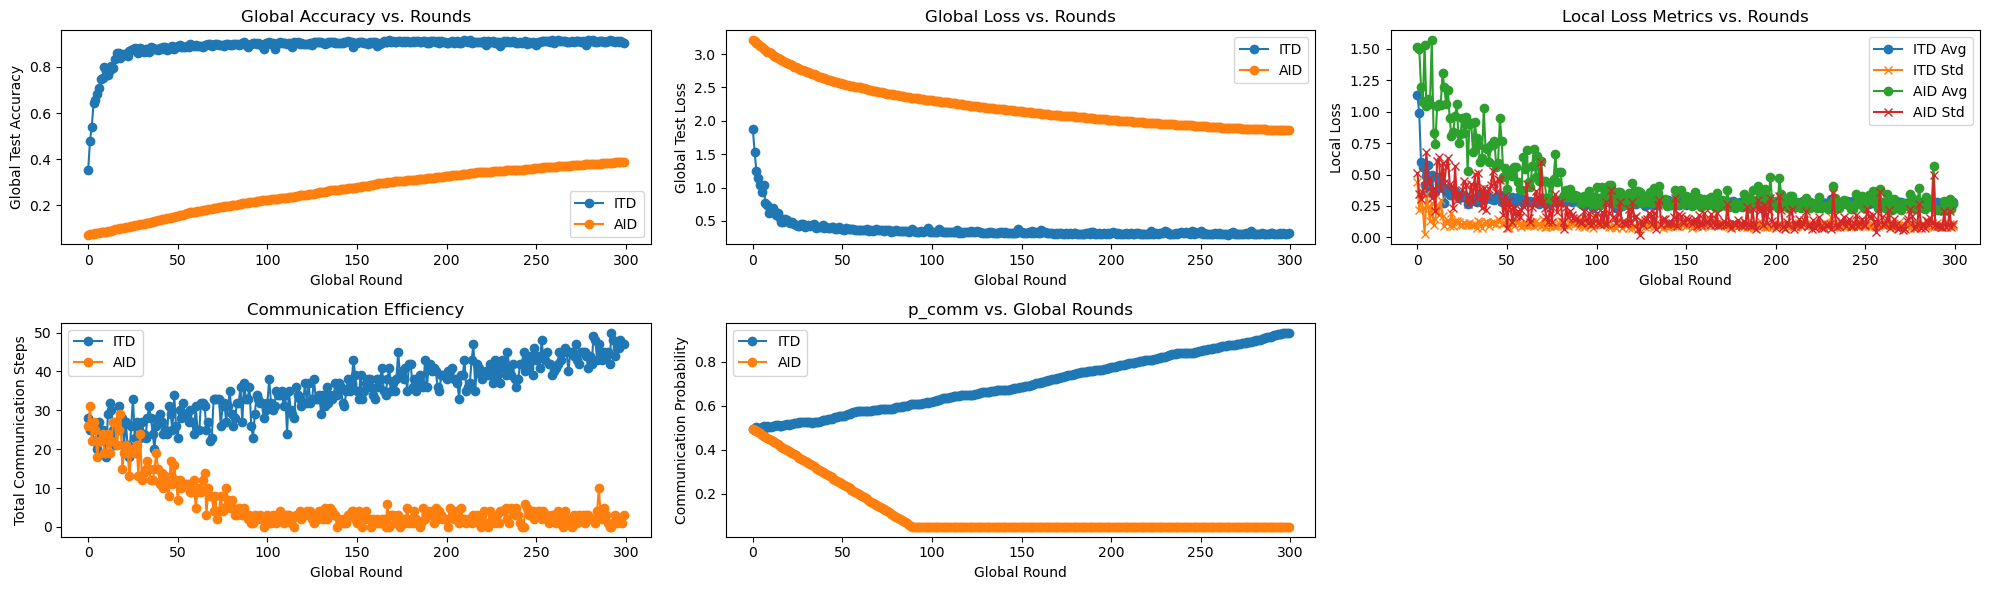


Final Client Accuracies:
ITD:
  Client 0: 0.9645
  Client 1: 0.8817
  Client 2: 0.8990
  Client 3: 0.9327
  Client 4: 0.9157
AID:
  Client 0: 0.9912
  Client 1: 0.9301
  Client 2: 0.9360
  Client 3: 0.9860
  Client 4: 0.9321


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

# =============================================================================
# User parameters: choose hypergradient method.
# We now run both "ITD" and "AID" and record metrics for each.
# =============================================================================
hypergrad_methods = ["ITD", "AID"]

# =============================================================================
# Setup & Data Loading
# =============================================================================
np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
num_clients = 5
indices = np.argsort(np.array(train_dataset.targets))
client_indices = np.array_split(indices, num_clients)
client_loaders = []
batch_size = 64
for idx in client_indices:
    subset = Subset(train_dataset, idx)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    client_loaders.append(loader)

# =============================================================================
# Model Definition and Utility Functions
# =============================================================================
d_in = 28 * 28
d_out = 10

def vector_to_model(vec):
    weight = vec[:d_in * d_out].view(d_in, d_out)
    bias = vec[d_in * d_out:].view(d_out)
    return (weight, bias)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    return X_flat @ weight + bias

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

# Initialize global model as a flat vector using Xavier initialization.
def init_global_vector():
    weight = torch.empty(d_in, d_out)
    nn.init.xavier_uniform_(weight)
    bias = torch.zeros(d_out)
    vec = torch.cat([weight.view(-1), bias.view(-1)])
    return vec.detach().clone().requires_grad_(True)

# Global update: update using hypergradient step.
def update_global_model(global_vec, hypergrad, lr):
    new_vec = global_vec - lr * hypergrad
    return new_vec.detach().clone().requires_grad_(True)

# =============================================================================
# Conjugate Gradient Solver for AID (used later)
# =============================================================================
def cg_solve(Ax_fn, b, tol=1e-5, max_iter=50):
    # Solve A v = b using conjugate gradient
    v = torch.zeros_like(b)
    r = b.clone()
    d = r.clone()
    delta_new = torch.dot(r, r)
    delta_0 = delta_new.clone()
    for i in range(max_iter):
        q = Ax_fn(d)
        alpha = delta_new / (torch.dot(d, q) + 1e-8)
        v = v + alpha * d
        r = r - alpha * q
        delta_old = delta_new
        delta_new = torch.dot(r, r)
        if delta_new < tol * delta_0:
            break
        beta = delta_new / (delta_old + 1e-8)
        d = r + beta * d
    return v

def flatten_grad(grads):
    return torch.cat([g.contiguous().view(-1) for g in grads])

# =============================================================================
# Hyperparameters
# =============================================================================
num_outer = 300         # Number of global rounds
max_inner = 10          # Number of local (inner) iterations per client
inner_lr = 0.01         # Local learning rate
global_lr = 0.2         # Global update step size (applied to hypergradient)
rho   = 0.1             # Consensus weight: keeps local model near global model
eta   = 0.1             # Fairness penalty weight
rel_tol = 0.005         # (Not used in this code, placeholder for inner loop stopping)
p_comm_init = 0.5       # Initial communication probability (for ProxSkip)
alpha_p = 0.01          # Step size for adapting communication probability

fd_eps = 1e-3           # For FD method (if needed)

# =============================================================================
# Evaluation Data Loader (MNIST test set)
# =============================================================================
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# =============================================================================
# Run Experiments for both ITD and AID
# =============================================================================
results = {}  # Dictionary to store metric histories for each method

for hypergrad_method in hypergrad_methods:
    print(f"\nRunning experiment with hypergradient method: {hypergrad_method}")
    
    # Initialize global model vector and communication probability.
    global_vec = init_global_vector()
    p_comm = p_comm_init
    
    # Lists to track metrics per global round.
    global_acc_history = []
    global_loss_history = []       # Global test loss
    local_loss_avg_history = []    # Average of local training loss (per round)
    local_loss_std_history = []    # Std deviation of local losses
    communication_history = []     # Total communication count per round
    p_comm_history = []            # Tracking communication probability over rounds
    client_acc_history = []        # Client accuracies (list-of-lists, one per round)
    fairness_history = []          # Std deviation of client accuracies

    for outer in range(num_outer):
        client_local_vecs = []    # Local vectors (unrolled updates; for ITD retain graph)
        comm_counts = []          # Communication count for each client
        client_accs = []          # Accuracy per client (evaluated on local training data)
        client_losses = []        # Average loss per client (on training partition)
    
        # Compute fairness target: evaluate global model on each client's training data.
        # (Here we use the minimum loss among the clients.)
        eval_losses = []
        for loader in client_loaders:
            loss_sum, count = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(vector_to_model(global_vec), X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
            eval_losses.append(loss_sum / count)
        fairness_target = min(eval_losses)
    
        # For ITD, we "unroll" inner updates (retain computation graph).
        unroll = (hypergrad_method == "ITD")
    
        # Run local (inner) updates for each client.
        for loader in client_loaders:
            if unroll:
                local_vec = global_vec.clone()  # keep computational graph
            else:
                local_vec = global_vec.detach().clone()
            local_vec.requires_grad_(True)
            comm_count = 0
            loader_iter = iter(loader)
    
            for inner in range(max_inner):
                try:
                    X_batch, y_batch = next(loader_iter)
                except StopIteration:
                    loader_iter = iter(loader)
                    X_batch, y_batch = next(loader_iter)
    
                # Inner objective: cross-entropy loss + consensus term + fairness penalty.
                loss_val = ce_loss(vector_to_model(local_vec), X_batch, y_batch)
                loss_target = 0.5  # fixed target for fairness (example value)
                fairness_penalty = eta * (F.relu(loss_val - loss_target))**2
                consensus = (rho / 2) * torch.norm(local_vec - global_vec)**2
                inner_obj = loss_val + consensus + fairness_penalty
    
                grad_local = torch.autograd.grad(inner_obj, local_vec, retain_graph=unroll)[0]
                local_vec = local_vec - inner_lr * grad_local
    
                # Communication step (simulate ProxSkip): with probability p_comm update by averaging with global.
                if np.random.rand() < p_comm:
                    if unroll:
                        local_vec = 0.5 * (local_vec + global_vec)
                    else:
                        local_vec = 0.5 * (local_vec + global_vec.detach())
                    comm_count += 1
    
            client_local_vecs.append(local_vec)
            comm_counts.append(comm_count)
    
            # Evaluate local model on the client’s training data.
            loss_sum, count = 0, 0
            correct, tot = 0, 0
            for X_batch, y_batch in loader:
                model_local = vector_to_model(local_vec.detach())
                loss = ce_loss(model_local, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
                preds = predict(model_local, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            client_losses.append(loss_sum / count)
            client_accs.append(correct / tot)
    
        # Compute hypergradient and update global model.
        if hypergrad_method == "ITD":
            # In ITD, define an outer loss as the average cross-entropy on one mini-batch per client using the unrolled local model.
            outer_loss = 0.0
            for i, loader in enumerate(client_loaders):
                try:
                    X_batch, y_batch = next(iter(loader))
                except StopIteration:
                    continue
                model_i = vector_to_model(client_local_vecs[i])
                outer_loss = outer_loss + ce_loss(model_i, X_batch, y_batch)
            outer_loss = outer_loss / num_clients
            hypergrad = torch.autograd.grad(outer_loss, global_vec)[0]
            global_vec = update_global_model(global_vec, hypergrad, global_lr)
            hypergrad_norm = hypergrad.norm().item()
    
    

        # Adaptive update of communication probability (for both ITD and AID)
        # Here we compare the extra client loss (over fairness target) with a target value.
        total_extra_loss = sum([max(0, loss - fairness_target) for loss in client_losses])
        target_extra_loss = 0.1 * num_clients  # You may adjust this target as needed.
        p_comm = np.clip(p_comm + alpha_p * (total_extra_loss - target_extra_loss), 0.05, 1.0)
    
        # Record metrics:
        p_comm_history.append(p_comm)
        communication_history.append(sum(comm_counts))
        client_acc_history.append(client_accs)
        avg_client_loss = np.mean(client_losses)
        local_loss_avg_history.append(avg_client_loss)
        local_loss_std_history.append(np.std(client_losses))
    
        # Evaluate global model on the external test set.
        test_loss_sum, test_count = 0, 0
        correct, tot = 0, 0
        for X_batch, y_batch in test_loader:
            model_test = vector_to_model(global_vec)
            loss = ce_loss(model_test, X_batch, y_batch).item()
            test_loss_sum += loss * X_batch.shape[0]
            test_count += X_batch.shape[0]
            preds = predict(model_test, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        global_test_loss = test_loss_sum / test_count
        global_test_acc = correct / tot
        global_acc_history.append(global_test_acc)
        global_loss_history.append(global_test_loss)
    
        fairness_history.append(np.std(client_accs))
    
        print(f"Round {outer:03d} [{hypergrad_method}]: Global Acc = {global_test_acc:.4f}, "
              f"Global Loss = {global_test_loss:.4f}, Avg Client Loss = {avg_client_loss:.4f}, "
              f"Std(Client Loss) = {np.std(client_losses):.4f}, Std(Client Acc) = {np.std(client_accs):.4f}, "
              f"Total Comm Steps = {sum(comm_counts)}, p_comm = {p_comm:.4f}, Hypergrad Norm = {hypergrad_norm:.4f}")
    
    # Store metrics for this method.
    results[hypergrad_method] = {
        "global_acc_history": global_acc_history,
        "global_loss_history": global_loss_history,
        "local_loss_avg_history": local_loss_avg_history,
        "local_loss_std_history": local_loss_std_history,
        "communication_history": communication_history,
        "p_comm_history": p_comm_history,
        "client_acc_history": client_acc_history,
        "fairness_history": fairness_history
    }
    
# =============================================================================
# Visualization of Metrics (Combined for ITD and AID)
# =============================================================================
rounds = np.arange(num_outer)
plt.figure(figsize=(20, 6))
colors = {"ITD": "blue", "AID": "green"}

# Global Accuracy vs. Rounds
plt.subplot(2, 3, 1)
for method in hypergrad_methods:
    plt.plot(rounds, results[method]["global_acc_history"], label=method, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("Global Accuracy vs. Rounds")
plt.legend()

# Global Loss vs. Rounds
plt.subplot(2, 3, 2)
for method in hypergrad_methods:
    plt.plot(rounds, results[method]["global_loss_history"], label=method, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Global Test Loss")
plt.title("Global Loss vs. Rounds")
plt.legend()

# Local Loss Metrics vs. Rounds
plt.subplot(2, 3, 3)
for method in hypergrad_methods:
    plt.plot(rounds, results[method]["local_loss_avg_history"], label=f"{method} Avg", marker='o')
    plt.plot(rounds, results[method]["local_loss_std_history"], label=f"{method} Std", marker='x')
plt.xlabel("Global Round")
plt.ylabel("Local Loss")
plt.title("Local Loss Metrics vs. Rounds")
plt.legend()

# Communication Steps vs. Rounds
plt.subplot(2, 3, 4)
for method in hypergrad_methods:
    plt.plot(rounds, results[method]["communication_history"], label=method, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Total Communication Steps")
plt.title("Communication Efficiency")
plt.legend()

# Communication Probability vs. Rounds
plt.subplot(2, 3, 5)
for method in hypergrad_methods:
    plt.plot(rounds, results[method]["p_comm_history"], label=method, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Communication Probability")
plt.title("p_comm vs. Global Rounds")
plt.legend()

plt.tight_layout()
plt.show()



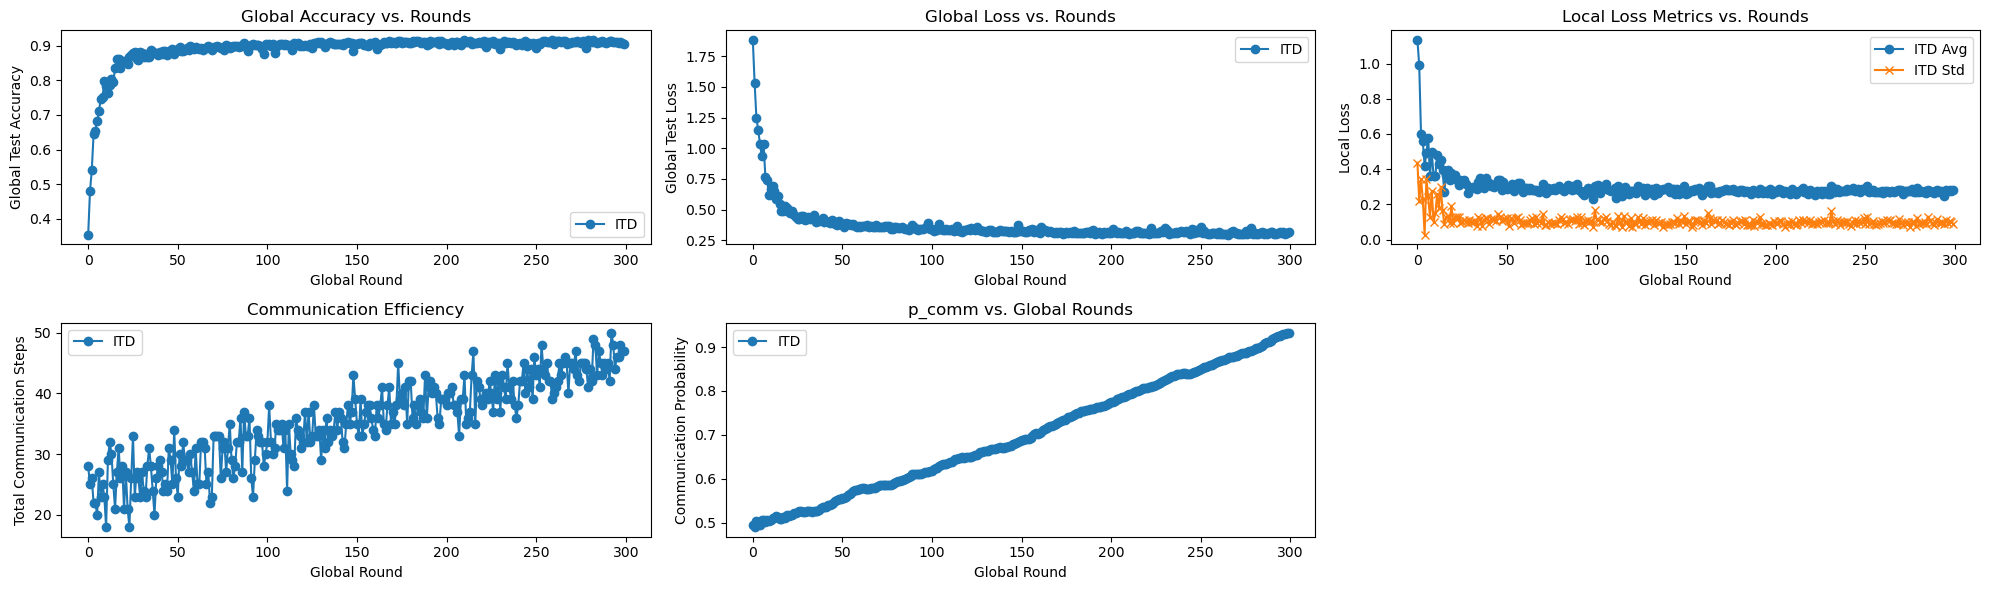


Final Client Accuracies:
ITD:
  Client 0: 0.9645
  Client 1: 0.8817
  Client 2: 0.8990
  Client 3: 0.9327
  Client 4: 0.9157


In [27]:
# =============================================================================
# Visualization of Metrics (Combined for ITD and AID)
# =============================================================================
rounds = np.arange(num_outer)
plt.figure(figsize=(20, 6))
colors = {"AID": "green"}

# Global Accuracy vs. Rounds
plt.subplot(2, 3, 1)
for method in hypergrad_methods:
    plt.plot(rounds, results[method]["global_acc_history"], label=method, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("Global Accuracy vs. Rounds")
plt.legend()

# Global Loss vs. Rounds
plt.subplot(2, 3, 2)
for method in hypergrad_methods:
    plt.plot(rounds, results[method]["global_loss_history"], label=method, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Global Test Loss")
plt.title("Global Loss vs. Rounds")
plt.legend()

# Local Loss Metrics vs. Rounds
plt.subplot(2, 3, 3)
for method in hypergrad_methods:
    plt.plot(rounds, results[method]["local_loss_avg_history"], label=f"{method} Avg", marker='o')
    plt.plot(rounds, results[method]["local_loss_std_history"], label=f"{method} Std", marker='x')
plt.xlabel("Global Round")
plt.ylabel("Local Loss")
plt.title("Local Loss Metrics vs. Rounds")
plt.legend()

# Communication Steps vs. Rounds
plt.subplot(2, 3, 4)
for method in hypergrad_methods:
    plt.plot(rounds, results[method]["communication_history"], label=method, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Total Communication Steps")
plt.title("Communication Efficiency")
plt.legend()

# Communication Probability vs. Rounds
plt.subplot(2, 3, 5)
for method in hypergrad_methods:
    plt.plot(rounds, results[method]["p_comm_history"], label=method, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Communication Probability")
plt.title("p_comm vs. Global Rounds")
plt.legend()

plt.tight_layout()
plt.show()

# Print final client accuracies for the last round (for both methods)
print("\nFinal Client Accuracies:")
hypergrad_methods = ["ITD"]
final_acc = results[method]["client_acc_history"][-1]
print(f"{method}:")
for i, acc in enumerate(final_acc):
    print(f"  Client {i}: {acc:.4f}")

In [ ]:
"""
ITD
'mean', 0.2, 0.01, 10
"""
# =============================================================================
# User parameters: choose hypergradient method.
# We now run both "ITD" and "AID" and record metrics for each.
# =============================================================================
hypergrad_methods = ["ITD"]

# =============================================================================
# Setup & Data Loading
# =============================================================================
np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
num_clients = 5
indices = np.argsort(np.array(train_dataset.targets))
client_indices = np.array_split(indices, num_clients)
client_loaders = []
batch_size = 64
for idx in client_indices:
    subset = Subset(train_dataset, idx)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    client_loaders.append(loader)

# =============================================================================
# Model Definition and Utility Functions
# =============================================================================
d_in = 28 * 28
d_out = 10

def vector_to_model(vec):
    weight = vec[:d_in * d_out].view(d_in, d_out)
    bias = vec[d_in * d_out:].view(d_out)
    return (weight, bias)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    return X_flat @ weight + bias

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

# Initialize global model as a flat vector using Xavier initialization.
def init_global_vector():
    weight = torch.empty(d_in, d_out)
    nn.init.xavier_uniform_(weight)
    bias = torch.zeros(d_out)
    vec = torch.cat([weight.view(-1), bias.view(-1)])
    return vec.detach().clone().requires_grad_(True)

# Global update: update using hypergradient step.
def update_global_model(global_vec, hypergrad, lr):
    new_vec = global_vec - lr * hypergrad
    return new_vec.detach().clone().requires_grad_(True)

# =============================================================================
# Conjugate Gradient Solver for AID (used later)
# =============================================================================
def cg_solve(Ax_fn, b, tol=1e-5, max_iter=50):
    # Solve A v = b using conjugate gradient
    v = torch.zeros_like(b)
    r = b.clone()
    d = r.clone()
    delta_new = torch.dot(r, r)
    delta_0 = delta_new.clone()
    for i in range(max_iter):
        q = Ax_fn(d)
        alpha = delta_new / (torch.dot(d, q) + 1e-8)
        v = v + alpha * d
        r = r - alpha * q
        delta_old = delta_new
        delta_new = torch.dot(r, r)
        if delta_new < tol * delta_0:
            break
        beta = delta_new / (delta_old + 1e-8)
        d = r + beta * d
    return v

def flatten_grad(grads):
    return torch.cat([g.contiguous().view(-1) for g in grads])

# =============================================================================
# Hyperparameters
# =============================================================================
num_outer = 300         # Number of global rounds
max_inner = 10          # Number of local (inner) iterations per client
inner_lr = 0.01         # Local learning rate
global_lr = 0.2         # Global update step size (applied to hypergradient)
rho   = 0.1             # Consensus weight: keeps local model near global model
eta   = 0.1             # Fairness penalty weight
rel_tol = 0.005         # (Not used in this code, placeholder for inner loop stopping)
p_comm_init = 0.5       # Initial communication probability (for ProxSkip)
alpha_p = 0.01          # Step size for adapting communication probability

fd_eps = 1e-3           # For FD method (if needed)

# =============================================================================
# Evaluation Data Loader (MNIST test set)
# =============================================================================
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# =============================================================================
# Run Experiments for both ITD and AID
# =============================================================================
results = {}  # Dictionary to store metric histories for each method

for hypergrad_method in hypergrad_methods:
    print(f"\nRunning experiment with hypergradient method: {hypergrad_method}")
    
    # Initialize global model vector and communication probability.
    global_vec = init_global_vector()
    p_comm = p_comm_init
    
    # Lists to track metrics per global round.
    global_acc_history = []
    global_loss_history = []       # Global test loss
    local_loss_avg_history = []    # Average of local training loss (per round)
    local_loss_std_history = []    # Std deviation of local losses
    communication_history = []     # Total communication count per round
    p_comm_history = []            # Tracking communication probability over rounds
    client_acc_history = []        # Client accuracies (list-of-lists, one per round)
    fairness_history = []          # Std deviation of client accuracies

    for outer in range(num_outer):
        client_local_vecs = []    # Local vectors (unrolled updates; for ITD retain graph)
        comm_counts = []          # Communication count for each client
        client_accs = []          # Accuracy per client (evaluated on local training data)
        client_losses = []        # Average loss per client (on training partition)
    
        # Compute fairness target: evaluate global model on each client's training data.
        # (Here we use the minimum loss among the clients.)
        eval_losses = []
        for loader in client_loaders:
            loss_sum, count = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(vector_to_model(global_vec), X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
            eval_losses.append(loss_sum / count)
        # fairness_target = min(eval_losses)
        fairness_target = np.mean(eval_losses)
    
        # For ITD, we "unroll" inner updates (retain computation graph).
        unroll = (hypergrad_method == "ITD")
    
        # Run local (inner) updates for each client.
        for loader in client_loaders:
            if unroll:
                local_vec = global_vec.clone()  # keep computational graph
            else:
                local_vec = global_vec.detach().clone()
            local_vec.requires_grad_(True)
            comm_count = 0
            loader_iter = iter(loader)
    
            for inner in range(max_inner):
                try:
                    X_batch, y_batch = next(loader_iter)
                except StopIteration:
                    loader_iter = iter(loader)
                    X_batch, y_batch = next(loader_iter)
    
                # Inner objective: cross-entropy loss + consensus term + fairness penalty.
                loss_val = ce_loss(vector_to_model(local_vec), X_batch, y_batch)
                loss_target = 0.5  # fixed target for fairness (example value)
                fairness_penalty = eta * (F.relu(loss_val - loss_target))**2
                consensus = (rho / 2) * torch.norm(local_vec - global_vec)**2
                inner_obj = loss_val + consensus + fairness_penalty
    
                grad_local = torch.autograd.grad(inner_obj, local_vec, retain_graph=unroll)[0]
                local_vec = local_vec - inner_lr * grad_local
    
                # Communication step (simulate ProxSkip): with probability p_comm update by averaging with global.
                if np.random.rand() < p_comm:
                    if unroll:
                        local_vec = 0.5 * (local_vec + global_vec)
                    else:
                        local_vec = 0.5 * (local_vec + global_vec.detach())
                    comm_count += 1
    
            client_local_vecs.append(local_vec)
            comm_counts.append(comm_count)
    
            # Evaluate local model on the client’s training data.
            loss_sum, count = 0, 0
            correct, tot = 0, 0
            for X_batch, y_batch in loader:
                model_local = vector_to_model(local_vec.detach())
                loss = ce_loss(model_local, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
                preds = predict(model_local, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            client_losses.append(loss_sum / count)
            client_accs.append(correct / tot)
    
        # Compute hypergradient and update global model.
        if hypergrad_method == "ITD":
            # In ITD, define an outer loss as the average cross-entropy on one mini-batch per client using the unrolled local model.
            outer_loss = 0.0
            for i, loader in enumerate(client_loaders):
                try:
                    X_batch, y_batch = next(iter(loader))
                except StopIteration:
                    continue
                model_i = vector_to_model(client_local_vecs[i])
                outer_loss = outer_loss + ce_loss(model_i, X_batch, y_batch)
            outer_loss = outer_loss / num_clients
            hypergrad = torch.autograd.grad(outer_loss, global_vec)[0]
            global_vec = update_global_model(global_vec, hypergrad, global_lr)
            hypergrad_norm = hypergrad.norm().item()
    
    

        # Adaptive update of communication probability (for both ITD and AID)
        # Here we compare the extra client loss (over fairness target) with a target value.
        total_extra_loss = sum([max(0, loss - fairness_target) for loss in client_losses])
        target_extra_loss = 0.1 * num_clients  # You may adjust this target as needed.
        p_comm = np.clip(p_comm + alpha_p * (total_extra_loss - target_extra_loss), 0.05, 1.0)
    
        # Record metrics:
        p_comm_history.append(p_comm)
        communication_history.append(sum(comm_counts))
        client_acc_history.append(client_accs)
        avg_client_loss = np.mean(client_losses)
        local_loss_avg_history.append(avg_client_loss)
        local_loss_std_history.append(np.std(client_losses))
    
        # Evaluate global model on the external test set.
        test_loss_sum, test_count = 0, 0
        correct, tot = 0, 0
        for X_batch, y_batch in test_loader:
            model_test = vector_to_model(global_vec)
            loss = ce_loss(model_test, X_batch, y_batch).item()
            test_loss_sum += loss * X_batch.shape[0]
            test_count += X_batch.shape[0]
            preds = predict(model_test, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        global_test_loss = test_loss_sum / test_count
        global_test_acc = correct / tot
        global_acc_history.append(global_test_acc)
        global_loss_history.append(global_test_loss)
    
        fairness_history.append(np.std(client_accs))
    
        print(f"Round {outer:03d} [{hypergrad_method}]: Global Acc = {global_test_acc:.4f}, "
              f"Global Loss = {global_test_loss:.4f}, Avg Client Loss = {avg_client_loss:.4f}, "
              f"Std(Client Loss) = {np.std(client_losses):.4f}, Std(Client Acc) = {np.std(client_accs):.4f}, "
              f"Total Comm Steps = {sum(comm_counts)}, p_comm = {p_comm:.4f}, Hypergrad Norm = {hypergrad_norm:.4f}")
    
    # Store metrics for this method.
    results[hypergrad_method] = {
        "global_acc_history": global_acc_history,
        "global_loss_history": global_loss_history,
        "local_loss_avg_history": local_loss_avg_history,
        "local_loss_std_history": local_loss_std_history,
        "communication_history": communication_history,
        "p_comm_history": p_comm_history,
        "client_acc_history": client_acc_history,
        "fairness_history": fairness_history
    }
    



Running experiment with hypergradient method: ITD
Round 000 [ITD]: Global Acc = 0.3546, Global Loss = 1.8814, Avg Client Loss = 1.1337, Std(Client Loss) = 0.4368, Std(Client Acc) = 0.1844, Total Comm Steps = 28, p_comm = 0.4950, Hypergrad Norm = 2.3523
Round 001 [ITD]: Global Acc = 0.4796, Global Loss = 1.5348, Avg Client Loss = 0.9893, Std(Client Loss) = 0.2170, Std(Client Acc) = 0.0885, Total Comm Steps = 25, p_comm = 0.4900, Hypergrad Norm = 2.5452
Round 002 [ITD]: Global Acc = 0.5404, Global Loss = 1.2481, Avg Client Loss = 0.5983, Std(Client Loss) = 0.3419, Std(Client Acc) = 0.1216, Total Comm Steps = 26, p_comm = 0.4850, Hypergrad Norm = 1.9256
Round 003 [ITD]: Global Acc = 0.6431, Global Loss = 1.1506, Avg Client Loss = 0.5564, Std(Client Loss) = 0.2307, Std(Client Acc) = 0.0976, Total Comm Steps = 21, p_comm = 0.4800, Hypergrad Norm = 1.8653
Round 004 [ITD]: Global Acc = 0.6541, Global Loss = 1.0352, Avg Client Loss = 0.4201, Std(Client Loss) = 0.0272, Std(Client Acc) = 0.0103

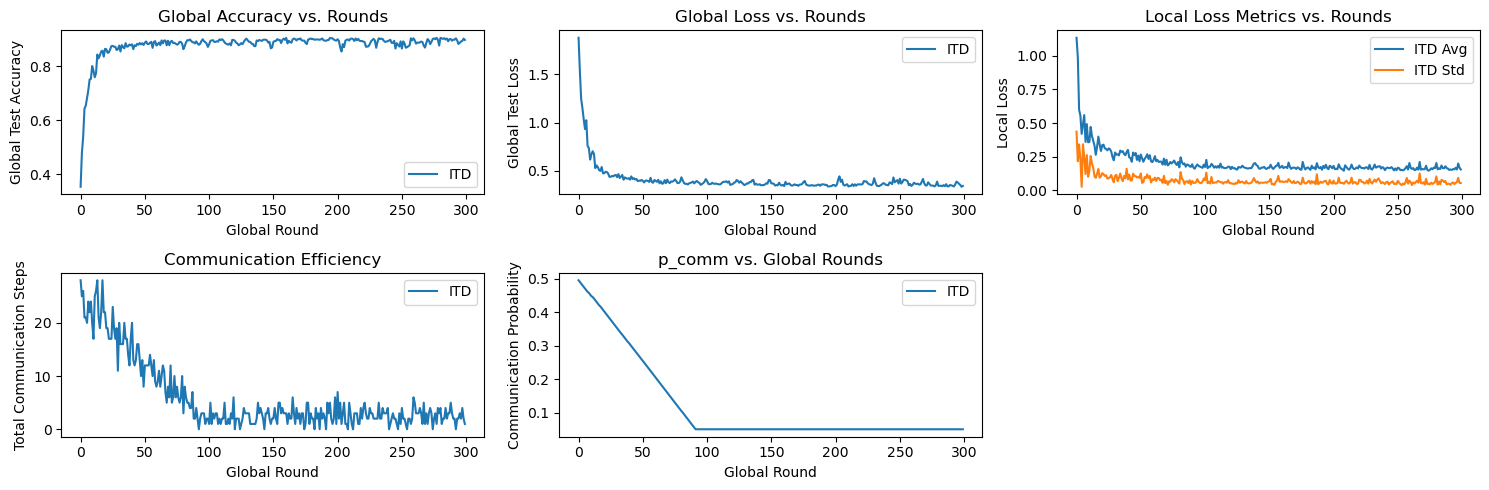

In [35]:
# =============================================================================
# Visualization of Metrics (Combined for ITD and AID)
# =============================================================================
rounds = np.arange(num_outer)
plt.figure(figsize=(15, 5))
colors = {"ITD": "blue"}

# Global Accuracy vs. Rounds
plt.subplot(2, 3, 1)
for method in hypergrad_methods:
    plt.plot(rounds, results[method]["global_acc_history"], label=method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("Global Accuracy vs. Rounds")
plt.legend()

# Global Loss vs. Rounds
plt.subplot(2, 3, 2)
for method in hypergrad_methods:
    plt.plot(rounds, results[method]["global_loss_history"], label=method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Loss")
plt.title("Global Loss vs. Rounds")
plt.legend()

# Local Loss Metrics vs. Rounds
plt.subplot(2, 3, 3)
for method in hypergrad_methods:
    # plt.plot(rounds, results[method]["local_loss_avg_history"], label=f"{method} Avg", marker='o')
    # plt.plot(rounds, results[method]["local_loss_std_history"], label=f"{method} Std", marker='x')
    plt.plot(rounds, results[method]["local_loss_avg_history"], label=f"{method} Avg")
    plt.plot(rounds, results[method]["local_loss_std_history"], label=f"{method} Std")
plt.xlabel("Global Round")
plt.ylabel("Local Loss")
plt.title("Local Loss Metrics vs. Rounds")
plt.legend()

# Communication Steps vs. Rounds
plt.subplot(2, 3, 4)
for method in hypergrad_methods:
    plt.plot(rounds, results[method]["communication_history"], label=method)
plt.xlabel("Global Round")
plt.ylabel("Total Communication Steps")
plt.title("Communication Efficiency")
plt.legend()

# Communication Probability vs. Rounds
plt.subplot(2, 3, 5)
for method in hypergrad_methods:
    plt.plot(rounds, results[method]["p_comm_history"], label=method)
plt.xlabel("Global Round")
plt.ylabel("Communication Probability")
plt.title("p_comm vs. Global Rounds")
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:

# =============================================================================
fairness_target = [min(eval_losses), np.mean(eval_losses)]          
global_lr      = [0.5, 0.2]                # global update step sizes
inner_lr      = [0.01, 0.1]               # local learning rates
max_inner     = [5, 10]                   # number of inner steps per round
hypergrad_methods = ['ITD']                # you can extend to ['ITD', 'AID']


In [40]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import itertools

# -----------------------------------------------------------------------------
# Hyperparameter grid
# -----------------------------------------------------------------------------
fairness_modes    = ['min', 'mean']
global_lrs        = [0.5, 0.2]
inner_lrs         = [0.01, 0.1]
max_inners        = [5, 10]
hypergrad_methods = ['ITD']   # or ['ITD','AID']

# -----------------------------------------------------------------------------
# Data & utilities
# -----------------------------------------------------------------------------
np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

num_clients    = 5
indices        = np.argsort(np.array(train_ds.targets))
client_indices = np.array_split(indices, num_clients)
client_loaders = [
    DataLoader(Subset(train_ds, idx), batch_size=64, shuffle=True)
    for idx in client_indices
]
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

d_in, d_out = 28*28, 10

def vector_to_model(vec):
    w = vec[:d_in*d_out].view(d_in, d_out)
    b = vec[d_in*d_out:].view(d_out)
    return (w, b)

def model_to_vector(model):
    w,b = model
    return torch.cat([w.view(-1), b.view(-1)])

def predict(model, X):
    w,b = model
    return X.view(X.size(0), -1) @ w + b

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

def init_global_vector():
    w = torch.empty(d_in, d_out)
    torch.nn.init.xavier_uniform_(w)
    b = torch.zeros(d_out)
    v = torch.cat([w.view(-1), b])
    return v.detach().clone().requires_grad_(True)

def update_global_model(g, hg, lr):
    new = g - lr * hg
    return new.detach().clone().requires_grad_(True)

# -----------------------------------------------------------------------------
# Grid search loop
# -----------------------------------------------------------------------------
results = {}

for fairness_mode, glr, ilr, mi, hyper_method \
    in itertools.product(fairness_modes, global_lrs, inner_lrs, max_inners, hypergrad_methods):

    cfg = f"{hyper_method}_fair-{fairness_mode}_glr{glr}_ilr{ilr}_mi{mi}"
    print(f"\n=== Starting config {cfg} ===")

    # initialize
    global_vec = init_global_vector()
    p_comm     = 0.5

    # histories (matched to your original names)
    global_acc_history      = []
    global_loss_history     = []
    local_loss_avg_history  = []
    local_loss_std_history  = []
    communication_history   = []
    p_comm_history          = []
    client_acc_history      = []
    fairness_history        = []
    hypergrad_norm_history  = []

    for outer in range(300):
        # — compute eval_losses for fairness target
        eval_losses = []
        for loader in client_loaders:
            s, c = 0.0, 0
            for Xb, yb in loader:
                s += ce_loss(vector_to_model(global_vec), Xb, yb).item() * Xb.size(0)
                c += Xb.size(0)
            eval_losses.append(s/c)
        fairness_target = min(eval_losses) if fairness_mode=='min' else np.mean(eval_losses)

        # — inner updates
        client_local_vecs = []
        comm_counts       = []
        client_losses     = []
        client_accs       = []

        for loader in client_loaders:
            lv = global_vec.clone().requires_grad_(hyper_method=='ITD')
            comm_cnt = 0
            it = iter(loader)

            for _ in range(mi):
                try:
                    Xb, yb = next(it)
                except StopIteration:
                    it = iter(loader)
                    Xb, yb = next(it)

                # inner objective
                loss_val = ce_loss(vector_to_model(lv), Xb, yb)
                consensus = 0.5 * 0.1 * torch.norm(lv - global_vec)**2
                fp        = 0.1 * (F.relu(loss_val - 0.5))**2
                obj_inner = loss_val + consensus + fp

                grad_lv = torch.autograd.grad(obj_inner, lv, retain_graph=(hyper_method=='ITD'))[0]
                lv = lv - ilr * grad_lv

                if np.random.rand() < p_comm:
                    lv = 0.5 * (lv + (global_vec if hyper_method=='ITD' else global_vec.detach()))
                    comm_cnt += 1

            client_local_vecs.append(lv)
            comm_counts.append(comm_cnt)

            # evaluate local
            s, c, corr = 0.0, 0, 0
            for Xb, yb in loader:
                mv = vector_to_model(lv.detach())
                l_ = ce_loss(mv, Xb, yb).item()
                s += l_ * Xb.size(0)
                c += Xb.size(0)
                preds = predict(mv, Xb).argmax(1)
                corr += (preds==yb).sum().item()
            client_losses.append(s/c)
            client_accs.append(corr/c)

        # — hypergradient & global update
        if hyper_method=='ITD':
            outer_loss = 0.0
            for lv, loader in zip(client_local_vecs, client_loaders):
                Xb, yb = next(iter(loader))
                outer_loss += ce_loss(vector_to_model(lv), Xb, yb)
            outer_loss = outer_loss / num_clients

            hypergrad = torch.autograd.grad(outer_loss, global_vec)[0]
            hypergrad_norm = hypergrad.norm().item()
            global_vec = update_global_model(global_vec, hypergrad, glr)
        else:
            # placeholder for AID
            hypergrad = torch.zeros_like(global_vec)
            hypergrad_norm = 0.0

        # — adapt p_comm
        extra = sum(max(0, L - fairness_target) for L in client_losses)
        p_comm = float(np.clip(p_comm + 0.01 * (extra - 0.1*num_clients), 0.05, 1.0))

        # — test‐set eval
        s, c, corr = 0.0, 0, 0
        for Xb, yb in test_loader:
            mv = vector_to_model(global_vec)
            l_ = ce_loss(mv, Xb, yb).item()
            s += l_ * Xb.size(0)
            c += Xb.size(0)
            preds = predict(mv, Xb).argmax(1)
            corr += (preds==yb).sum().item()

        global_test_loss = s / c
        global_test_acc  = corr / c
        avg_client_loss = np.mean(client_losses)

        # — print exactly your f‑string every round
        print(f"Round {outer:03d} [{hyper_method}]: "
              f"Global Acc = {global_test_acc:.4f}, "
              f"Global Loss = {global_test_loss:.4f}, "
              f"Avg Client Loss = {avg_client_loss:.4f}, "
              f"Std(Client Loss) = {np.std(client_losses):.4f}, "
              f"Std(Client Acc) = {np.std(client_accs):.4f}, "
              f"Total Comm Steps = {sum(comm_counts)}, "
              f"p_comm = {p_comm:.4f}, "
              f"Hypergrad Norm = {hypergrad_norm:.4f}"
        )

        # — append to histories
        global_acc_history.append(global_test_acc)
        global_loss_history.append(global_test_loss)
        local_loss_avg_history.append(avg_client_loss)
        local_loss_std_history.append(np.std(client_losses))
        communication_history.append(sum(comm_counts))
        p_comm_history.append(p_comm)
        client_acc_history.append(client_accs)
        fairness_history.append(np.std(client_accs))
        hypergrad_norm_history.append(hypergrad_norm)

    # — store for this config
    results[cfg] = {
        "global_acc_history":     global_acc_history,
        "global_loss_history":    global_loss_history,
        "local_loss_avg_history": local_loss_avg_history,
        "local_loss_std_history": local_loss_std_history,
        "communication_history":  communication_history,
        "p_comm_history":         p_comm_history,
        "client_acc_history":     client_acc_history,
        "fairness_history":       fairness_history,
        "hypergrad_norm_history": hypergrad_norm_history,
    }



=== Starting config ITD_fair-min_glr0.5_ilr0.01_mi5 ===
Round 000 [ITD]: Global Acc = 0.3394, Global Loss = 4.8668, Avg Client Loss = 1.3463, Std(Client Loss) = 0.4392, Std(Client Acc) = 0.1665, Total Comm Steps = 15, p_comm = 0.4950, Hypergrad Norm = 3.1904
Round 001 [ITD]: Global Acc = 0.3428, Global Loss = 8.0944, Avg Client Loss = 1.3868, Std(Client Loss) = 0.8388, Std(Client Acc) = 0.2442, Total Comm Steps = 12, p_comm = 0.5406, Hypergrad Norm = 4.6913
Round 002 [ITD]: Global Acc = 0.2984, Global Loss = 6.8408, Avg Client Loss = 2.9228, Std(Client Loss) = 2.1577, Std(Client Acc) = 0.3206, Total Comm Steps = 12, p_comm = 0.6706, Hypergrad Norm = 4.9327
Round 003 [ITD]: Global Acc = 0.4428, Global Loss = 7.1554, Avg Client Loss = 3.2382, Std(Client Loss) = 1.9990, Std(Client Acc) = 0.2495, Total Comm Steps = 17, p_comm = 0.7862, Hypergrad Norm = 6.7694
Round 004 [ITD]: Global Acc = 0.5588, Global Loss = 5.9352, Avg Client Loss = 4.4728, Std(Client Loss) = 5.0696, Std(Client Acc) = 


=== Plotting for global_lr = 0.5 ===


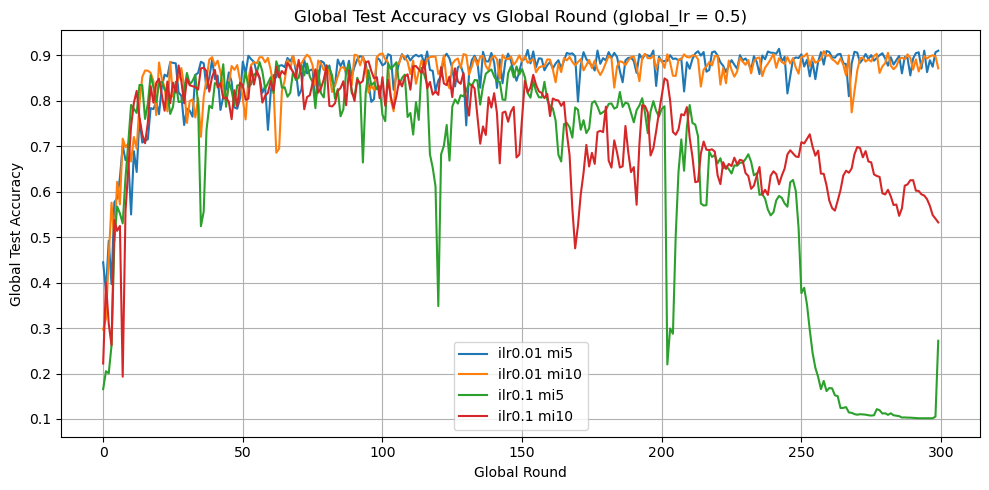

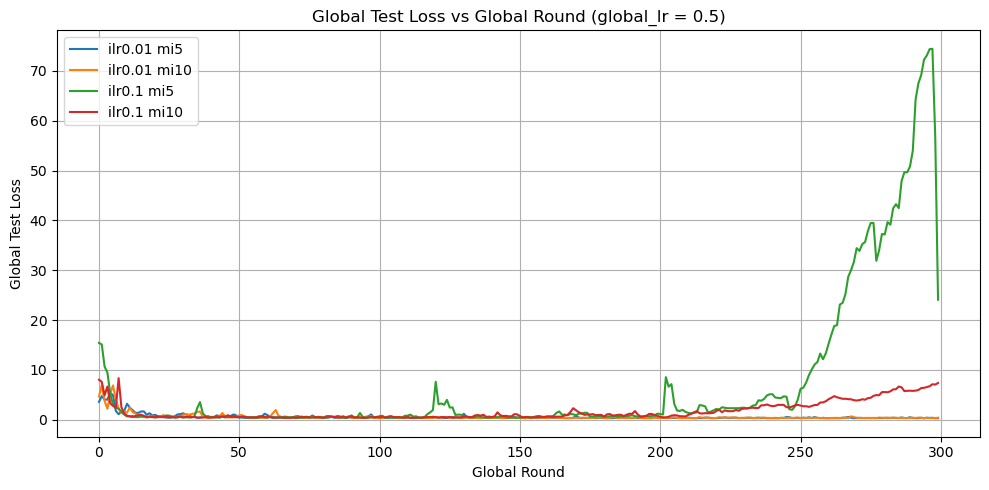

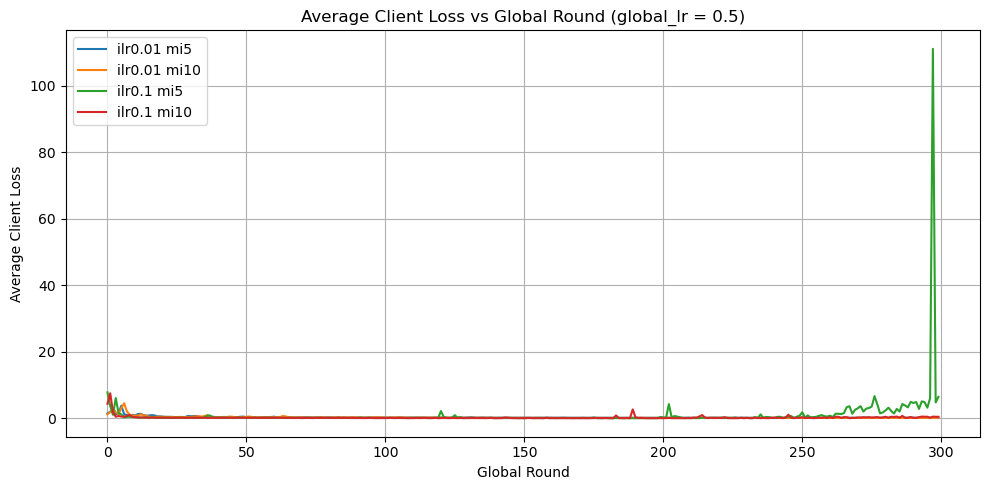

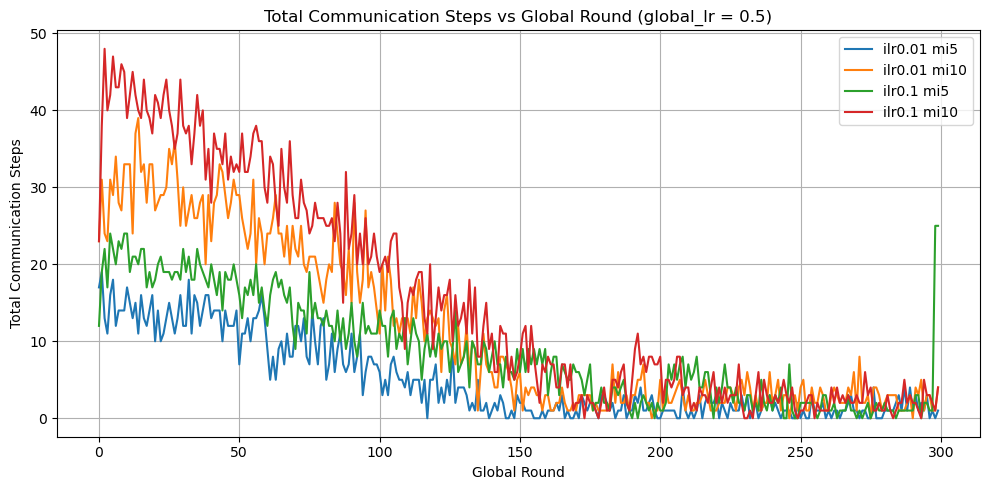

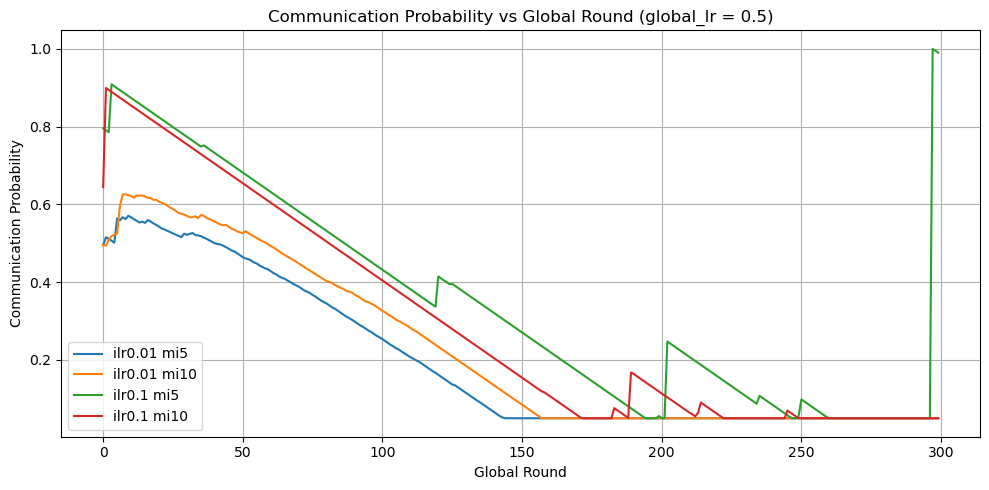


=== Plotting for global_lr = 0.2 ===


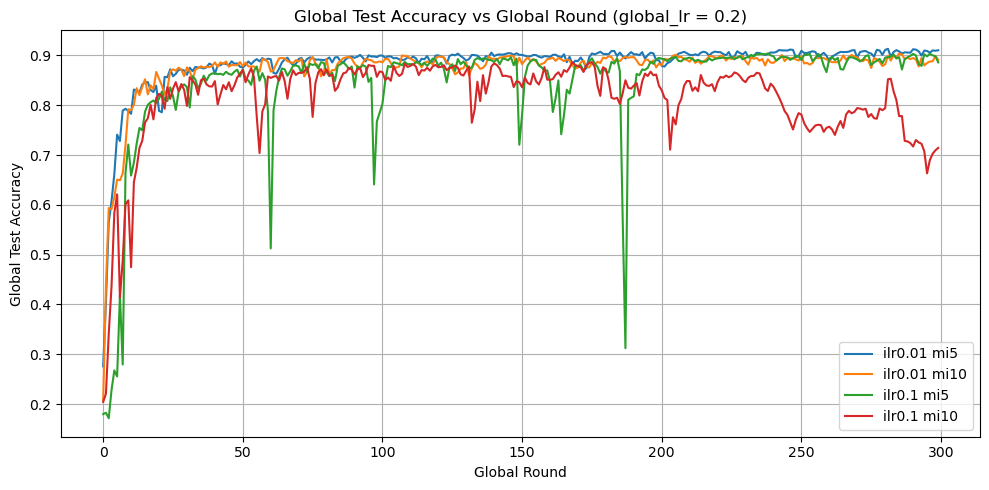

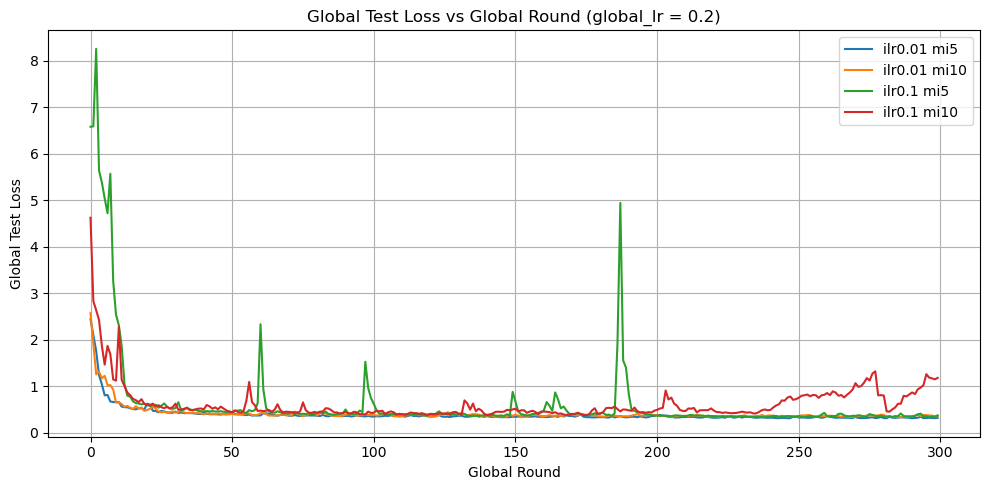

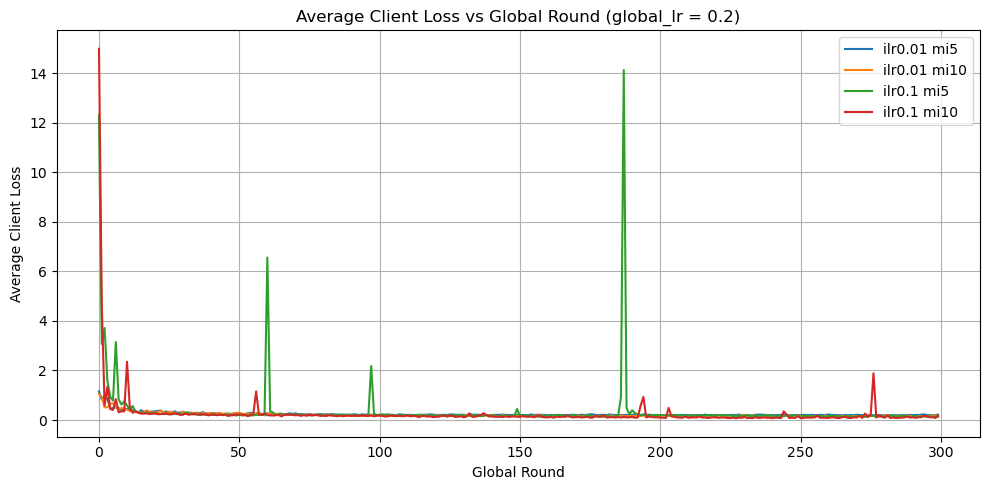

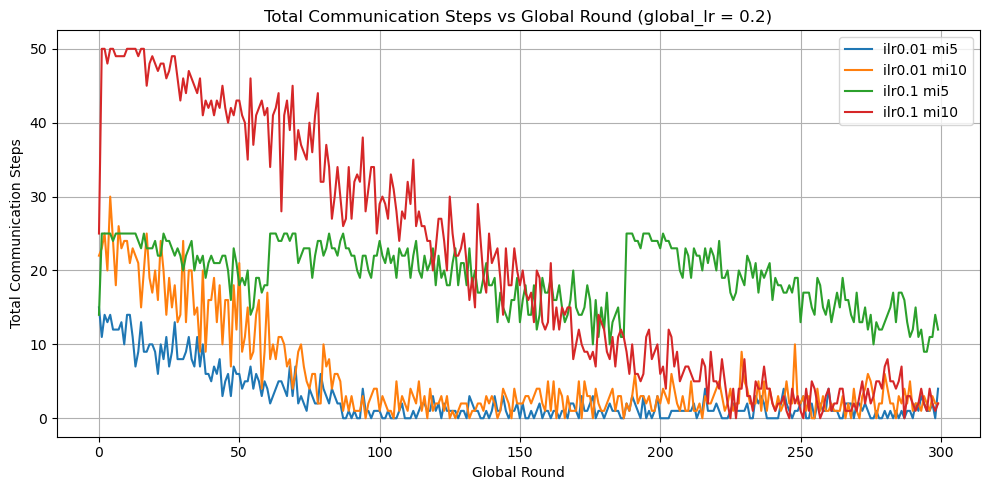

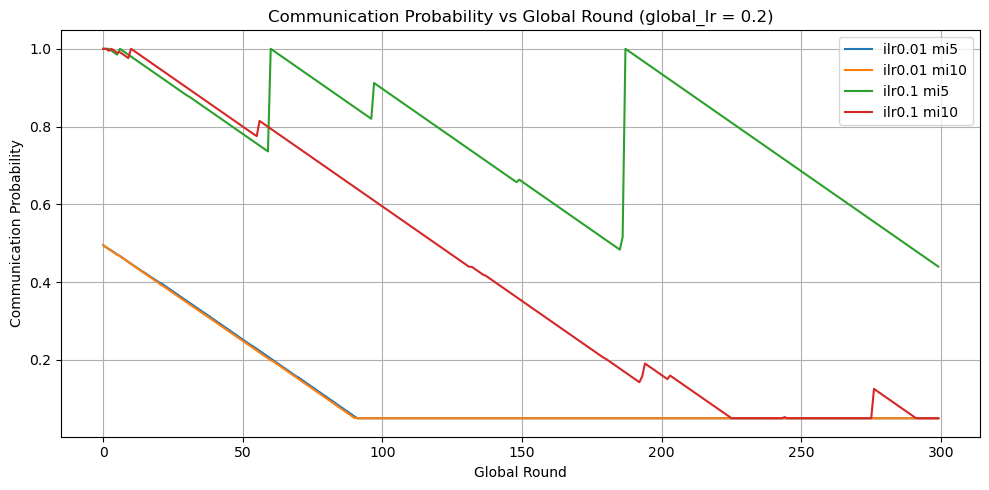

In [43]:
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# Filter configs for fairness='mean' and separate by global_lr
# -----------------------------------------------------------------------------
for glr_val in [0.5, 0.2]:
    filtered = {
        cfg: hist for cfg, hist in results.items()
        if f"fair-mean_glr{glr_val}" in cfg
    }

    # Metric names and labels
    metrics = {
        'global_acc_history':     'Global Test Accuracy',
        'global_loss_history':    'Global Test Loss',
        'local_loss_avg_history': 'Average Client Loss',
        'communication_history':  'Total Communication Steps',
        'p_comm_history':         'Communication Probability'
    }

    rounds = list(range(len(next(iter(filtered.values()))['global_acc_history'])))

    print(f"\n=== Plotting for global_lr = {glr_val} ===")
    
    for key, title in metrics.items():
        plt.figure(figsize=(10, 5))
        for cfg, hist in filtered.items():
            # Extract a readable label from cfg
            label = cfg.replace(f'ITD_fair-mean_glr{glr_val}_', '').replace('_', ' ')
            plt.plot(rounds, hist[key], label=label)
        plt.xlabel('Global Round')
        plt.ylabel(title)
        plt.title(f'{title} vs Global Round (global_lr = {glr_val})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
